In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1t2_native_k5_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 474)
(3944610, 8)
validation
(464344, 474)
(464344, 8)
test
(574820, 474)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 474)]             0         


 dense (Dense)               (None, 1024)              486400    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1176456 (4.49 MB)


Trainable params: 1176456 (4.49 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:20 - loss: 2.2209 - STD: 0.0551 - MAE: 0.2198

  5/395 [..............................] - ETA: 5s - loss: 2.1089 - STD: 0.0536 - MAE: 0.2164  

 10/395 [..............................] - ETA: 4s - loss: 2.0880 - STD: 0.0451 - MAE: 0.2166

 15/395 [>.............................] - ETA: 4s - loss: 2.0800 - STD: 0.0395 - MAE: 0.2168

 20/395 [>.............................] - ETA: 4s - loss: 2.0734 - STD: 0.0385 - MAE: 0.2168

 25/395 [>.............................] - ETA: 4s - loss: 2.0697 - STD: 0.0381 - MAE: 0.2167

 30/395 [=>............................] - ETA: 4s - loss: 2.0664 - STD: 0.0373 - MAE: 0.2167

 35/395 [=>............................] - ETA: 4s - loss: 2.0646 - STD: 0.0365 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 4s - loss: 2.0631 - STD: 0.0356 - MAE: 0.2167

 45/395 [==>...........................] - ETA: 4s - loss: 2.0617 - STD: 0.0355 - MAE: 0.2167

 50/395 [==>...........................] - ETA: 4s - loss: 2.0603 - STD: 0.0352 - MAE: 0.2167

 55/395 [===>..........................] - ETA: 4s - loss: 2.0592 - STD: 0.0348 - MAE: 0.2167

 60/395 [===>..........................] - ETA: 4s - loss: 2.0582 - STD: 0.0346 - MAE: 0.2167

 65/395 [===>..........................] - ETA: 3s - loss: 2.0570 - STD: 0.0344 - MAE: 0.2167

 70/395 [====>.........................] - ETA: 3s - loss: 2.0555 - STD: 0.0343 - MAE: 0.2166

 75/395 [====>.........................] - ETA: 3s - loss: 2.0533 - STD: 0.0343 - MAE: 0.2165

 80/395 [=====>........................] - ETA: 3s - loss: 2.0504 - STD: 0.0346 - MAE: 0.2164

 85/395 [=====>........................] - ETA: 3s - loss: 2.0469 - STD: 0.0353 - MAE: 0.2163

 90/395 [=====>........................] - ETA: 3s - loss: 2.0430 - STD: 0.0363 - MAE: 0.2160

 94/395 [======>.......................] - ETA: 3s - loss: 2.0393 - STD: 0.0371 - MAE: 0.2158

 99/395 [======>.......................] - ETA: 3s - loss: 2.0346 - STD: 0.0383 - MAE: 0.2156

104/395 [======>.......................] - ETA: 3s - loss: 2.0299 - STD: 0.0394 - MAE: 0.2153

109/395 [=======>......................] - ETA: 3s - loss: 2.0247 - STD: 0.0406 - MAE: 0.2150

111/395 [=======>......................] - ETA: 5s - loss: 2.0233 - STD: 0.0411 - MAE: 0.2149

116/395 [=======>......................] - ETA: 4s - loss: 2.0185 - STD: 0.0424 - MAE: 0.2146

121/395 [========>.....................] - ETA: 4s - loss: 2.0134 - STD: 0.0436 - MAE: 0.2143

126/395 [========>.....................] - ETA: 4s - loss: 2.0085 - STD: 0.0448 - MAE: 0.2140

131/395 [========>.....................] - ETA: 4s - loss: 2.0033 - STD: 0.0459 - MAE: 0.2138

136/395 [=========>....................] - ETA: 4s - loss: 1.9982 - STD: 0.0470 - MAE: 0.2135

141/395 [=========>....................] - ETA: 4s - loss: 1.9933 - STD: 0.0482 - MAE: 0.2132

146/395 [==========>...................] - ETA: 4s - loss: 1.9881 - STD: 0.0492 - MAE: 0.2129

151/395 [==========>...................] - ETA: 3s - loss: 1.9833 - STD: 0.0503 - MAE: 0.2126

156/395 [==========>...................] - ETA: 3s - loss: 1.9784 - STD: 0.0514 - MAE: 0.2123

161/395 [===========>..................] - ETA: 3s - loss: 1.9737 - STD: 0.0525 - MAE: 0.2120

166/395 [===========>..................] - ETA: 3s - loss: 1.9692 - STD: 0.0535 - MAE: 0.2117

171/395 [===========>..................] - ETA: 3s - loss: 1.9646 - STD: 0.0545 - MAE: 0.2114

176/395 [============>.................] - ETA: 3s - loss: 1.9605 - STD: 0.0555 - MAE: 0.2111

181/395 [============>.................] - ETA: 3s - loss: 1.9562 - STD: 0.0565 - MAE: 0.2108

186/395 [=============>................] - ETA: 3s - loss: 1.9523 - STD: 0.0575 - MAE: 0.2106

191/395 [=============>................] - ETA: 3s - loss: 1.9483 - STD: 0.0584 - MAE: 0.2103

196/395 [=============>................] - ETA: 3s - loss: 1.9444 - STD: 0.0593 - MAE: 0.2101

201/395 [==============>...............] - ETA: 2s - loss: 1.9409 - STD: 0.0602 - MAE: 0.2098

205/395 [==============>...............] - ETA: 2s - loss: 1.9383 - STD: 0.0609 - MAE: 0.2096

210/395 [==============>...............] - ETA: 2s - loss: 1.9350 - STD: 0.0617 - MAE: 0.2094

215/395 [===============>..............] - ETA: 2s - loss: 1.9316 - STD: 0.0624 - MAE: 0.2092

220/395 [===============>..............] - ETA: 2s - loss: 1.9284 - STD: 0.0632 - MAE: 0.2090

225/395 [================>.............] - ETA: 2s - loss: 1.9253 - STD: 0.0639 - MAE: 0.2087

230/395 [================>.............] - ETA: 2s - loss: 1.9221 - STD: 0.0647 - MAE: 0.2085

235/395 [================>.............] - ETA: 2s - loss: 1.9190 - STD: 0.0654 - MAE: 0.2083

240/395 [=================>............] - ETA: 2s - loss: 1.9161 - STD: 0.0661 - MAE: 0.2081

245/395 [=================>............] - ETA: 2s - loss: 1.9132 - STD: 0.0667 - MAE: 0.2079

250/395 [=================>............] - ETA: 2s - loss: 1.9104 - STD: 0.0674 - MAE: 0.2077

255/395 [==================>...........] - ETA: 2s - loss: 1.9076 - STD: 0.0680 - MAE: 0.2075

259/395 [==================>...........] - ETA: 1s - loss: 1.9054 - STD: 0.0685 - MAE: 0.2074

264/395 [===================>..........] - ETA: 1s - loss: 1.9029 - STD: 0.0691 - MAE: 0.2072

269/395 [===================>..........] - ETA: 1s - loss: 1.9003 - STD: 0.0697 - MAE: 0.2071

274/395 [===================>..........] - ETA: 1s - loss: 1.8978 - STD: 0.0702 - MAE: 0.2069

279/395 [====================>.........] - ETA: 1s - loss: 1.8953 - STD: 0.0708 - MAE: 0.2067

283/395 [====================>.........] - ETA: 1s - loss: 1.8933 - STD: 0.0712 - MAE: 0.2066

288/395 [====================>.........] - ETA: 1s - loss: 1.8908 - STD: 0.0718 - MAE: 0.2064

293/395 [=====================>........] - ETA: 1s - loss: 1.8884 - STD: 0.0723 - MAE: 0.2062

298/395 [=====================>........] - ETA: 1s - loss: 1.8860 - STD: 0.0728 - MAE: 0.2061

303/395 [======================>.......] - ETA: 1s - loss: 1.8834 - STD: 0.0733 - MAE: 0.2059

308/395 [======================>.......] - ETA: 1s - loss: 1.8810 - STD: 0.0738 - MAE: 0.2057

313/395 [======================>.......] - ETA: 1s - loss: 1.8787 - STD: 0.0743 - MAE: 0.2056

318/395 [=======================>......] - ETA: 1s - loss: 1.8764 - STD: 0.0749 - MAE: 0.2054

323/395 [=======================>......] - ETA: 1s - loss: 1.8742 - STD: 0.0754 - MAE: 0.2053

328/395 [=======================>......] - ETA: 0s - loss: 1.8719 - STD: 0.0758 - MAE: 0.2051

333/395 [========================>.....] - ETA: 0s - loss: 1.8696 - STD: 0.0763 - MAE: 0.2050

338/395 [========================>.....] - ETA: 0s - loss: 1.8673 - STD: 0.0768 - MAE: 0.2048

343/395 [=========================>....] - ETA: 0s - loss: 1.8650 - STD: 0.0772 - MAE: 0.2047

348/395 [=========================>....] - ETA: 0s - loss: 1.8627 - STD: 0.0777 - MAE: 0.2045

353/395 [=========================>....] - ETA: 0s - loss: 1.8605 - STD: 0.0782 - MAE: 0.2044

358/395 [==========================>...] - ETA: 0s - loss: 1.8583 - STD: 0.0786 - MAE: 0.2042

363/395 [==========================>...] - ETA: 0s - loss: 1.8562 - STD: 0.0791 - MAE: 0.2041

368/395 [==========================>...] - ETA: 0s - loss: 1.8543 - STD: 0.0795 - MAE: 0.2039

373/395 [===========================>..] - ETA: 0s - loss: 1.8523 - STD: 0.0800 - MAE: 0.2038

378/395 [===========================>..] - ETA: 0s - loss: 1.8503 - STD: 0.0804 - MAE: 0.2036

383/395 [============================>.] - ETA: 0s - loss: 1.8483 - STD: 0.0808 - MAE: 0.2035

388/395 [============================>.] - ETA: 0s - loss: 1.8462 - STD: 0.0812 - MAE: 0.2034

393/395 [============================>.] - ETA: 0s - loss: 1.8443 - STD: 0.0816 - MAE: 0.2032

395/395 [==============================] - 8s 16ms/step - loss: 1.8435 - STD: 0.0818 - MAE: 0.2032 - val_loss: 1.6395 - val_STD: 0.1074 - val_MAE: 0.1910


Epoch 2/10000


  1/395 [..............................] - ETA: 13s - loss: 1.6818 - STD: 0.1124 - MAE: 0.1924

  6/395 [..............................] - ETA: 4s - loss: 1.6840 - STD: 0.1119 - MAE: 0.1927 

 11/395 [..............................] - ETA: 4s - loss: 1.6826 - STD: 0.1127 - MAE: 0.1924

 16/395 [>.............................] - ETA: 4s - loss: 1.6830 - STD: 0.1132 - MAE: 0.1923

 21/395 [>.............................] - ETA: 4s - loss: 1.6818 - STD: 0.1134 - MAE: 0.1922

 26/395 [>.............................] - ETA: 4s - loss: 1.6804 - STD: 0.1136 - MAE: 0.1922

 31/395 [=>............................] - ETA: 4s - loss: 1.6805 - STD: 0.1138 - MAE: 0.1921

 36/395 [=>............................] - ETA: 4s - loss: 1.6796 - STD: 0.1138 - MAE: 0.1921

 41/395 [==>...........................] - ETA: 4s - loss: 1.6787 - STD: 0.1141 - MAE: 0.1920

 46/395 [==>...........................] - ETA: 4s - loss: 1.6778 - STD: 0.1142 - MAE: 0.1919

 51/395 [==>...........................] - ETA: 4s - loss: 1.6774 - STD: 0.1144 - MAE: 0.1919

 56/395 [===>..........................] - ETA: 4s - loss: 1.6778 - STD: 0.1144 - MAE: 0.1919

 61/395 [===>..........................] - ETA: 3s - loss: 1.6772 - STD: 0.1146 - MAE: 0.1918

 66/395 [====>.........................] - ETA: 3s - loss: 1.6763 - STD: 0.1146 - MAE: 0.1918

 71/395 [====>.........................] - ETA: 3s - loss: 1.6755 - STD: 0.1147 - MAE: 0.1917

 76/395 [====>.........................] - ETA: 3s - loss: 1.6750 - STD: 0.1147 - MAE: 0.1917

 81/395 [=====>........................] - ETA: 3s - loss: 1.6746 - STD: 0.1148 - MAE: 0.1917

 86/395 [=====>........................] - ETA: 3s - loss: 1.6738 - STD: 0.1150 - MAE: 0.1916

 91/395 [=====>........................] - ETA: 3s - loss: 1.6732 - STD: 0.1150 - MAE: 0.1916

 95/395 [======>.......................] - ETA: 3s - loss: 1.6723 - STD: 0.1151 - MAE: 0.1915

 99/395 [======>.......................] - ETA: 3s - loss: 1.6718 - STD: 0.1152 - MAE: 0.1915

104/395 [======>.......................] - ETA: 3s - loss: 1.6711 - STD: 0.1153 - MAE: 0.1915

109/395 [=======>......................] - ETA: 3s - loss: 1.6705 - STD: 0.1155 - MAE: 0.1914

114/395 [=======>......................] - ETA: 3s - loss: 1.6699 - STD: 0.1156 - MAE: 0.1913

119/395 [========>.....................] - ETA: 3s - loss: 1.6693 - STD: 0.1157 - MAE: 0.1913

124/395 [========>.....................] - ETA: 3s - loss: 1.6688 - STD: 0.1158 - MAE: 0.1913

129/395 [========>.....................] - ETA: 3s - loss: 1.6684 - STD: 0.1158 - MAE: 0.1912

134/395 [=========>....................] - ETA: 3s - loss: 1.6679 - STD: 0.1160 - MAE: 0.1912

139/395 [=========>....................] - ETA: 3s - loss: 1.6674 - STD: 0.1161 - MAE: 0.1911

144/395 [=========>....................] - ETA: 3s - loss: 1.6673 - STD: 0.1162 - MAE: 0.1911

149/395 [==========>...................] - ETA: 2s - loss: 1.6669 - STD: 0.1163 - MAE: 0.1911

154/395 [==========>...................] - ETA: 2s - loss: 1.6666 - STD: 0.1163 - MAE: 0.1910

159/395 [===========>..................] - ETA: 2s - loss: 1.6662 - STD: 0.1164 - MAE: 0.1910

164/395 [===========>..................] - ETA: 2s - loss: 1.6655 - STD: 0.1165 - MAE: 0.1909

169/395 [===========>..................] - ETA: 2s - loss: 1.6651 - STD: 0.1165 - MAE: 0.1909

174/395 [============>.................] - ETA: 2s - loss: 1.6646 - STD: 0.1166 - MAE: 0.1909

179/395 [============>.................] - ETA: 2s - loss: 1.6643 - STD: 0.1167 - MAE: 0.1908

184/395 [============>.................] - ETA: 2s - loss: 1.6638 - STD: 0.1168 - MAE: 0.1908

189/395 [=============>................] - ETA: 2s - loss: 1.6632 - STD: 0.1169 - MAE: 0.1908

194/395 [=============>................] - ETA: 2s - loss: 1.6627 - STD: 0.1170 - MAE: 0.1907

199/395 [==============>...............] - ETA: 2s - loss: 1.6621 - STD: 0.1171 - MAE: 0.1907

204/395 [==============>...............] - ETA: 2s - loss: 1.6618 - STD: 0.1171 - MAE: 0.1906

209/395 [==============>...............] - ETA: 2s - loss: 1.6619 - STD: 0.1172 - MAE: 0.1906

214/395 [===============>..............] - ETA: 2s - loss: 1.6618 - STD: 0.1173 - MAE: 0.1906

219/395 [===============>..............] - ETA: 2s - loss: 1.6614 - STD: 0.1173 - MAE: 0.1906

224/395 [================>.............] - ETA: 2s - loss: 1.6609 - STD: 0.1174 - MAE: 0.1905

229/395 [================>.............] - ETA: 1s - loss: 1.6603 - STD: 0.1175 - MAE: 0.1905

234/395 [================>.............] - ETA: 1s - loss: 1.6598 - STD: 0.1175 - MAE: 0.1905

239/395 [=================>............] - ETA: 1s - loss: 1.6594 - STD: 0.1176 - MAE: 0.1904

244/395 [=================>............] - ETA: 1s - loss: 1.6593 - STD: 0.1177 - MAE: 0.1904

249/395 [=================>............] - ETA: 1s - loss: 1.6591 - STD: 0.1178 - MAE: 0.1904

254/395 [==================>...........] - ETA: 1s - loss: 1.6590 - STD: 0.1178 - MAE: 0.1904

259/395 [==================>...........] - ETA: 1s - loss: 1.6588 - STD: 0.1179 - MAE: 0.1903

264/395 [===================>..........] - ETA: 1s - loss: 1.6583 - STD: 0.1179 - MAE: 0.1903

269/395 [===================>..........] - ETA: 1s - loss: 1.6579 - STD: 0.1180 - MAE: 0.1903

274/395 [===================>..........] - ETA: 1s - loss: 1.6575 - STD: 0.1181 - MAE: 0.1903

279/395 [====================>.........] - ETA: 1s - loss: 1.6570 - STD: 0.1181 - MAE: 0.1902

284/395 [====================>.........] - ETA: 1s - loss: 1.6566 - STD: 0.1182 - MAE: 0.1902

289/395 [====================>.........] - ETA: 1s - loss: 1.6564 - STD: 0.1183 - MAE: 0.1902

294/395 [=====================>........] - ETA: 1s - loss: 1.6561 - STD: 0.1183 - MAE: 0.1902

299/395 [=====================>........] - ETA: 1s - loss: 1.6558 - STD: 0.1184 - MAE: 0.1901

304/395 [======================>.......] - ETA: 1s - loss: 1.6554 - STD: 0.1184 - MAE: 0.1901

309/395 [======================>.......] - ETA: 1s - loss: 1.6550 - STD: 0.1185 - MAE: 0.1901

314/395 [======================>.......] - ETA: 0s - loss: 1.6545 - STD: 0.1186 - MAE: 0.1900

319/395 [=======================>......] - ETA: 0s - loss: 1.6542 - STD: 0.1186 - MAE: 0.1900

324/395 [=======================>......] - ETA: 0s - loss: 1.6538 - STD: 0.1187 - MAE: 0.1900

329/395 [=======================>......] - ETA: 0s - loss: 1.6535 - STD: 0.1188 - MAE: 0.1899

334/395 [========================>.....] - ETA: 0s - loss: 1.6533 - STD: 0.1188 - MAE: 0.1899

339/395 [========================>.....] - ETA: 0s - loss: 1.6529 - STD: 0.1189 - MAE: 0.1899

344/395 [=========================>....] - ETA: 0s - loss: 1.6525 - STD: 0.1189 - MAE: 0.1899

349/395 [=========================>....] - ETA: 0s - loss: 1.6523 - STD: 0.1190 - MAE: 0.1898

354/395 [=========================>....] - ETA: 0s - loss: 1.6522 - STD: 0.1191 - MAE: 0.1898

359/395 [==========================>...] - ETA: 0s - loss: 1.6523 - STD: 0.1191 - MAE: 0.1898

364/395 [==========================>...] - ETA: 0s - loss: 1.6522 - STD: 0.1191 - MAE: 0.1898

369/395 [===========================>..] - ETA: 0s - loss: 1.6520 - STD: 0.1192 - MAE: 0.1898

374/395 [===========================>..] - ETA: 0s - loss: 1.6517 - STD: 0.1192 - MAE: 0.1898

379/395 [===========================>..] - ETA: 0s - loss: 1.6514 - STD: 0.1193 - MAE: 0.1897

384/395 [============================>.] - ETA: 0s - loss: 1.6511 - STD: 0.1193 - MAE: 0.1897

389/395 [============================>.] - ETA: 0s - loss: 1.6507 - STD: 0.1194 - MAE: 0.1897

394/395 [============================>.] - ETA: 0s - loss: 1.6503 - STD: 0.1194 - MAE: 0.1897

395/395 [==============================] - 5s 13ms/step - loss: 1.6502 - STD: 0.1194 - MAE: 0.1897 - val_loss: 1.6003 - val_STD: 0.1180 - val_MAE: 0.1869


Epoch 3/10000


  1/395 [..............................] - ETA: 14s - loss: 1.6248 - STD: 0.1217 - MAE: 0.1884

  6/395 [..............................] - ETA: 4s - loss: 1.6194 - STD: 0.1250 - MAE: 0.1870 

 11/395 [..............................] - ETA: 4s - loss: 1.6202 - STD: 0.1248 - MAE: 0.1872

 16/395 [>.............................] - ETA: 4s - loss: 1.6208 - STD: 0.1244 - MAE: 0.1873

 21/395 [>.............................] - ETA: 4s - loss: 1.6201 - STD: 0.1245 - MAE: 0.1872

 26/395 [>.............................] - ETA: 4s - loss: 1.6199 - STD: 0.1244 - MAE: 0.1872

 31/395 [=>............................] - ETA: 4s - loss: 1.6193 - STD: 0.1244 - MAE: 0.1872

 36/395 [=>............................] - ETA: 4s - loss: 1.6186 - STD: 0.1245 - MAE: 0.1872

 41/395 [==>...........................] - ETA: 4s - loss: 1.6184 - STD: 0.1245 - MAE: 0.1872

 46/395 [==>...........................] - ETA: 4s - loss: 1.6184 - STD: 0.1245 - MAE: 0.1872

 51/395 [==>...........................] - ETA: 4s - loss: 1.6174 - STD: 0.1246 - MAE: 0.1871

 56/395 [===>..........................] - ETA: 4s - loss: 1.6189 - STD: 0.1248 - MAE: 0.1871

 61/395 [===>..........................] - ETA: 3s - loss: 1.6201 - STD: 0.1248 - MAE: 0.1872

 66/395 [====>.........................] - ETA: 3s - loss: 1.6214 - STD: 0.1248 - MAE: 0.1872

 71/395 [====>.........................] - ETA: 3s - loss: 1.6214 - STD: 0.1247 - MAE: 0.1872

 76/395 [====>.........................] - ETA: 3s - loss: 1.6214 - STD: 0.1247 - MAE: 0.1873

 81/395 [=====>........................] - ETA: 3s - loss: 1.6209 - STD: 0.1247 - MAE: 0.1872

 86/395 [=====>........................] - ETA: 3s - loss: 1.6204 - STD: 0.1247 - MAE: 0.1872

 91/395 [=====>........................] - ETA: 3s - loss: 1.6199 - STD: 0.1246 - MAE: 0.1872

 96/395 [======>.......................] - ETA: 3s - loss: 1.6197 - STD: 0.1247 - MAE: 0.1872

101/395 [======>.......................] - ETA: 3s - loss: 1.6195 - STD: 0.1247 - MAE: 0.1872

106/395 [=======>......................] - ETA: 3s - loss: 1.6194 - STD: 0.1247 - MAE: 0.1872

111/395 [=======>......................] - ETA: 3s - loss: 1.6192 - STD: 0.1248 - MAE: 0.1871

116/395 [=======>......................] - ETA: 3s - loss: 1.6191 - STD: 0.1248 - MAE: 0.1871

121/395 [========>.....................] - ETA: 3s - loss: 1.6187 - STD: 0.1249 - MAE: 0.1871

126/395 [========>.....................] - ETA: 3s - loss: 1.6187 - STD: 0.1248 - MAE: 0.1871

131/395 [========>.....................] - ETA: 3s - loss: 1.6184 - STD: 0.1249 - MAE: 0.1871

136/395 [=========>....................] - ETA: 3s - loss: 1.6184 - STD: 0.1249 - MAE: 0.1871

141/395 [=========>....................] - ETA: 3s - loss: 1.6179 - STD: 0.1250 - MAE: 0.1870

146/395 [==========>...................] - ETA: 2s - loss: 1.6178 - STD: 0.1250 - MAE: 0.1870

151/395 [==========>...................] - ETA: 2s - loss: 1.6176 - STD: 0.1251 - MAE: 0.1870

156/395 [==========>...................] - ETA: 2s - loss: 1.6173 - STD: 0.1251 - MAE: 0.1870

161/395 [===========>..................] - ETA: 2s - loss: 1.6170 - STD: 0.1252 - MAE: 0.1870

166/395 [===========>..................] - ETA: 2s - loss: 1.6169 - STD: 0.1252 - MAE: 0.1869

171/395 [===========>..................] - ETA: 2s - loss: 1.6168 - STD: 0.1252 - MAE: 0.1869

176/395 [============>.................] - ETA: 2s - loss: 1.6167 - STD: 0.1252 - MAE: 0.1869

181/395 [============>.................] - ETA: 2s - loss: 1.6165 - STD: 0.1252 - MAE: 0.1869

186/395 [=============>................] - ETA: 2s - loss: 1.6162 - STD: 0.1252 - MAE: 0.1869

191/395 [=============>................] - ETA: 2s - loss: 1.6160 - STD: 0.1253 - MAE: 0.1869

196/395 [=============>................] - ETA: 2s - loss: 1.6155 - STD: 0.1253 - MAE: 0.1868

201/395 [==============>...............] - ETA: 2s - loss: 1.6151 - STD: 0.1254 - MAE: 0.1868

206/395 [==============>...............] - ETA: 2s - loss: 1.6149 - STD: 0.1254 - MAE: 0.1868

211/395 [===============>..............] - ETA: 2s - loss: 1.6146 - STD: 0.1255 - MAE: 0.1868

216/395 [===============>..............] - ETA: 2s - loss: 1.6145 - STD: 0.1255 - MAE: 0.1868

221/395 [===============>..............] - ETA: 2s - loss: 1.6142 - STD: 0.1255 - MAE: 0.1868

226/395 [================>.............] - ETA: 2s - loss: 1.6140 - STD: 0.1256 - MAE: 0.1867

231/395 [================>.............] - ETA: 1s - loss: 1.6138 - STD: 0.1256 - MAE: 0.1867

236/395 [================>.............] - ETA: 1s - loss: 1.6136 - STD: 0.1257 - MAE: 0.1867

241/395 [=================>............] - ETA: 1s - loss: 1.6134 - STD: 0.1257 - MAE: 0.1867

246/395 [=================>............] - ETA: 1s - loss: 1.6131 - STD: 0.1257 - MAE: 0.1867

251/395 [==================>...........] - ETA: 1s - loss: 1.6129 - STD: 0.1257 - MAE: 0.1866

256/395 [==================>...........] - ETA: 1s - loss: 1.6126 - STD: 0.1258 - MAE: 0.1866

261/395 [==================>...........] - ETA: 1s - loss: 1.6123 - STD: 0.1258 - MAE: 0.1866

266/395 [===================>..........] - ETA: 1s - loss: 1.6120 - STD: 0.1259 - MAE: 0.1866

271/395 [===================>..........] - ETA: 1s - loss: 1.6120 - STD: 0.1259 - MAE: 0.1866

275/395 [===================>..........] - ETA: 1s - loss: 1.6119 - STD: 0.1259 - MAE: 0.1866

280/395 [====================>.........] - ETA: 1s - loss: 1.6119 - STD: 0.1259 - MAE: 0.1866

285/395 [====================>.........] - ETA: 1s - loss: 1.6117 - STD: 0.1260 - MAE: 0.1865

290/395 [=====================>........] - ETA: 1s - loss: 1.6115 - STD: 0.1260 - MAE: 0.1865

295/395 [=====================>........] - ETA: 1s - loss: 1.6113 - STD: 0.1260 - MAE: 0.1865

300/395 [=====================>........] - ETA: 1s - loss: 1.6111 - STD: 0.1260 - MAE: 0.1865

305/395 [======================>.......] - ETA: 1s - loss: 1.6108 - STD: 0.1261 - MAE: 0.1865

310/395 [======================>.......] - ETA: 1s - loss: 1.6106 - STD: 0.1261 - MAE: 0.1865

315/395 [======================>.......] - ETA: 0s - loss: 1.6104 - STD: 0.1261 - MAE: 0.1864

320/395 [=======================>......] - ETA: 0s - loss: 1.6102 - STD: 0.1262 - MAE: 0.1864

325/395 [=======================>......] - ETA: 0s - loss: 1.6100 - STD: 0.1262 - MAE: 0.1864

330/395 [========================>.....] - ETA: 0s - loss: 1.6099 - STD: 0.1263 - MAE: 0.1864

335/395 [========================>.....] - ETA: 0s - loss: 1.6097 - STD: 0.1263 - MAE: 0.1864

340/395 [========================>.....] - ETA: 0s - loss: 1.6096 - STD: 0.1263 - MAE: 0.1864

345/395 [=========================>....] - ETA: 0s - loss: 1.6096 - STD: 0.1263 - MAE: 0.1864

350/395 [=========================>....] - ETA: 0s - loss: 1.6096 - STD: 0.1264 - MAE: 0.1864

355/395 [=========================>....] - ETA: 0s - loss: 1.6097 - STD: 0.1264 - MAE: 0.1864

360/395 [==========================>...] - ETA: 0s - loss: 1.6097 - STD: 0.1264 - MAE: 0.1864

365/395 [==========================>...] - ETA: 0s - loss: 1.6097 - STD: 0.1264 - MAE: 0.1864

370/395 [===========================>..] - ETA: 0s - loss: 1.6097 - STD: 0.1264 - MAE: 0.1864

375/395 [===========================>..] - ETA: 0s - loss: 1.6099 - STD: 0.1264 - MAE: 0.1864

380/395 [===========================>..] - ETA: 0s - loss: 1.6100 - STD: 0.1264 - MAE: 0.1864

385/395 [============================>.] - ETA: 0s - loss: 1.6099 - STD: 0.1264 - MAE: 0.1864

390/395 [============================>.] - ETA: 0s - loss: 1.6097 - STD: 0.1264 - MAE: 0.1863

395/395 [==============================] - ETA: 0s - loss: 1.6095 - STD: 0.1264 - MAE: 0.1863

395/395 [==============================] - 5s 13ms/step - loss: 1.6095 - STD: 0.1264 - MAE: 0.1863 - val_loss: 1.5975 - val_STD: 0.1226 - val_MAE: 0.1854


Epoch 4/10000


  1/395 [..............................] - ETA: 15s - loss: 1.5889 - STD: 0.1293 - MAE: 0.1850

  5/395 [..............................] - ETA: 4s - loss: 1.5942 - STD: 0.1278 - MAE: 0.1855 

 10/395 [..............................] - ETA: 4s - loss: 1.5936 - STD: 0.1284 - MAE: 0.1852

 15/395 [>.............................] - ETA: 4s - loss: 1.5914 - STD: 0.1285 - MAE: 0.1851

 20/395 [>.............................] - ETA: 4s - loss: 1.5913 - STD: 0.1284 - MAE: 0.1851

 25/395 [>.............................] - ETA: 4s - loss: 1.5911 - STD: 0.1285 - MAE: 0.1850

 30/395 [=>............................] - ETA: 4s - loss: 1.5914 - STD: 0.1287 - MAE: 0.1850

 35/395 [=>............................] - ETA: 4s - loss: 1.5923 - STD: 0.1288 - MAE: 0.1850

 40/395 [==>...........................] - ETA: 4s - loss: 1.5929 - STD: 0.1287 - MAE: 0.1851

 45/395 [==>...........................] - ETA: 4s - loss: 1.5931 - STD: 0.1288 - MAE: 0.1851

 50/395 [==>...........................] - ETA: 4s - loss: 1.5939 - STD: 0.1288 - MAE: 0.1851

 55/395 [===>..........................] - ETA: 4s - loss: 1.5935 - STD: 0.1289 - MAE: 0.1851

 60/395 [===>..........................] - ETA: 3s - loss: 1.5941 - STD: 0.1290 - MAE: 0.1851

 65/395 [===>..........................] - ETA: 3s - loss: 1.5944 - STD: 0.1289 - MAE: 0.1851

 70/395 [====>.........................] - ETA: 3s - loss: 1.5940 - STD: 0.1290 - MAE: 0.1851

 75/395 [====>.........................] - ETA: 3s - loss: 1.5937 - STD: 0.1289 - MAE: 0.1851

 80/395 [=====>........................] - ETA: 3s - loss: 1.5933 - STD: 0.1289 - MAE: 0.1850

 85/395 [=====>........................] - ETA: 3s - loss: 1.5937 - STD: 0.1290 - MAE: 0.1850

 90/395 [=====>........................] - ETA: 3s - loss: 1.5940 - STD: 0.1289 - MAE: 0.1851

 95/395 [======>.......................] - ETA: 3s - loss: 1.5941 - STD: 0.1290 - MAE: 0.1851

100/395 [======>.......................] - ETA: 3s - loss: 1.5938 - STD: 0.1290 - MAE: 0.1850

105/395 [======>.......................] - ETA: 3s - loss: 1.5937 - STD: 0.1290 - MAE: 0.1850

110/395 [=======>......................] - ETA: 3s - loss: 1.5942 - STD: 0.1290 - MAE: 0.1850

115/395 [=======>......................] - ETA: 3s - loss: 1.5943 - STD: 0.1291 - MAE: 0.1850

120/395 [========>.....................] - ETA: 3s - loss: 1.5946 - STD: 0.1291 - MAE: 0.1851

125/395 [========>.....................] - ETA: 3s - loss: 1.5946 - STD: 0.1291 - MAE: 0.1851

130/395 [========>.....................] - ETA: 3s - loss: 1.5942 - STD: 0.1290 - MAE: 0.1850

135/395 [=========>....................] - ETA: 3s - loss: 1.5940 - STD: 0.1290 - MAE: 0.1850

140/395 [=========>....................] - ETA: 3s - loss: 1.5937 - STD: 0.1290 - MAE: 0.1850

145/395 [==========>...................] - ETA: 2s - loss: 1.5930 - STD: 0.1290 - MAE: 0.1850

150/395 [==========>...................] - ETA: 2s - loss: 1.5923 - STD: 0.1291 - MAE: 0.1850

155/395 [==========>...................] - ETA: 2s - loss: 1.5921 - STD: 0.1292 - MAE: 0.1849

160/395 [===========>..................] - ETA: 2s - loss: 1.5919 - STD: 0.1292 - MAE: 0.1849

165/395 [===========>..................] - ETA: 2s - loss: 1.5917 - STD: 0.1292 - MAE: 0.1849

170/395 [===========>..................] - ETA: 2s - loss: 1.5914 - STD: 0.1293 - MAE: 0.1849

175/395 [============>.................] - ETA: 2s - loss: 1.5912 - STD: 0.1293 - MAE: 0.1849

180/395 [============>.................] - ETA: 2s - loss: 1.5909 - STD: 0.1293 - MAE: 0.1849

185/395 [=============>................] - ETA: 2s - loss: 1.5906 - STD: 0.1293 - MAE: 0.1848

190/395 [=============>................] - ETA: 2s - loss: 1.5903 - STD: 0.1293 - MAE: 0.1848

195/395 [=============>................] - ETA: 2s - loss: 1.5902 - STD: 0.1294 - MAE: 0.1848

200/395 [==============>...............] - ETA: 2s - loss: 1.5902 - STD: 0.1294 - MAE: 0.1848

205/395 [==============>...............] - ETA: 2s - loss: 1.5899 - STD: 0.1295 - MAE: 0.1848

210/395 [==============>...............] - ETA: 2s - loss: 1.5897 - STD: 0.1295 - MAE: 0.1848

215/395 [===============>..............] - ETA: 2s - loss: 1.5896 - STD: 0.1295 - MAE: 0.1848

220/395 [===============>..............] - ETA: 2s - loss: 1.5895 - STD: 0.1295 - MAE: 0.1847

225/395 [================>.............] - ETA: 2s - loss: 1.5892 - STD: 0.1295 - MAE: 0.1847

230/395 [================>.............] - ETA: 1s - loss: 1.5889 - STD: 0.1296 - MAE: 0.1847

235/395 [================>.............] - ETA: 1s - loss: 1.5889 - STD: 0.1296 - MAE: 0.1847

240/395 [=================>............] - ETA: 1s - loss: 1.5889 - STD: 0.1296 - MAE: 0.1847

245/395 [=================>............] - ETA: 1s - loss: 1.5890 - STD: 0.1296 - MAE: 0.1847

250/395 [=================>............] - ETA: 1s - loss: 1.5891 - STD: 0.1297 - MAE: 0.1847

255/395 [==================>...........] - ETA: 1s - loss: 1.5893 - STD: 0.1297 - MAE: 0.1847

260/395 [==================>...........] - ETA: 1s - loss: 1.5893 - STD: 0.1297 - MAE: 0.1847

265/395 [===================>..........] - ETA: 1s - loss: 1.5895 - STD: 0.1296 - MAE: 0.1847

270/395 [===================>..........] - ETA: 1s - loss: 1.5894 - STD: 0.1296 - MAE: 0.1847

275/395 [===================>..........] - ETA: 1s - loss: 1.5893 - STD: 0.1296 - MAE: 0.1847

280/395 [====================>.........] - ETA: 1s - loss: 1.5891 - STD: 0.1297 - MAE: 0.1847

285/395 [====================>.........] - ETA: 1s - loss: 1.5890 - STD: 0.1297 - MAE: 0.1847

290/395 [=====================>........] - ETA: 1s - loss: 1.5888 - STD: 0.1297 - MAE: 0.1847

295/395 [=====================>........] - ETA: 1s - loss: 1.5886 - STD: 0.1297 - MAE: 0.1847

299/395 [=====================>........] - ETA: 1s - loss: 1.5884 - STD: 0.1297 - MAE: 0.1846

303/395 [======================>.......] - ETA: 1s - loss: 1.5883 - STD: 0.1297 - MAE: 0.1846

308/395 [======================>.......] - ETA: 1s - loss: 1.5881 - STD: 0.1297 - MAE: 0.1846

313/395 [======================>.......] - ETA: 0s - loss: 1.5878 - STD: 0.1298 - MAE: 0.1846

318/395 [=======================>......] - ETA: 0s - loss: 1.5875 - STD: 0.1298 - MAE: 0.1846

322/395 [=======================>......] - ETA: 0s - loss: 1.5873 - STD: 0.1299 - MAE: 0.1846

326/395 [=======================>......] - ETA: 0s - loss: 1.5871 - STD: 0.1299 - MAE: 0.1846

330/395 [========================>.....] - ETA: 0s - loss: 1.5869 - STD: 0.1299 - MAE: 0.1845

334/395 [========================>.....] - ETA: 0s - loss: 1.5868 - STD: 0.1299 - MAE: 0.1845

338/395 [========================>.....] - ETA: 0s - loss: 1.5866 - STD: 0.1300 - MAE: 0.1845

342/395 [========================>.....] - ETA: 0s - loss: 1.5864 - STD: 0.1300 - MAE: 0.1845

347/395 [=========================>....] - ETA: 0s - loss: 1.5863 - STD: 0.1300 - MAE: 0.1845

352/395 [=========================>....] - ETA: 0s - loss: 1.5861 - STD: 0.1300 - MAE: 0.1845

357/395 [==========================>...] - ETA: 0s - loss: 1.5859 - STD: 0.1301 - MAE: 0.1845

362/395 [==========================>...] - ETA: 0s - loss: 1.5856 - STD: 0.1301 - MAE: 0.1844

367/395 [==========================>...] - ETA: 0s - loss: 1.5853 - STD: 0.1301 - MAE: 0.1844

372/395 [===========================>..] - ETA: 0s - loss: 1.5850 - STD: 0.1301 - MAE: 0.1844

376/395 [===========================>..] - ETA: 0s - loss: 1.5849 - STD: 0.1301 - MAE: 0.1844

381/395 [===========================>..] - ETA: 0s - loss: 1.5847 - STD: 0.1302 - MAE: 0.1844

386/395 [============================>.] - ETA: 0s - loss: 1.5847 - STD: 0.1302 - MAE: 0.1844

391/395 [============================>.] - ETA: 0s - loss: 1.5845 - STD: 0.1302 - MAE: 0.1844

395/395 [==============================] - 5s 13ms/step - loss: 1.5845 - STD: 0.1302 - MAE: 0.1844 - val_loss: 1.5866 - val_STD: 0.1254 - val_MAE: 0.1841


Epoch 5/10000


  1/395 [..............................] - ETA: 15s - loss: 1.5703 - STD: 0.1312 - MAE: 0.1837

  5/395 [..............................] - ETA: 5s - loss: 1.5755 - STD: 0.1293 - MAE: 0.1844 

 10/395 [..............................] - ETA: 5s - loss: 1.5741 - STD: 0.1303 - MAE: 0.1840

 15/395 [>.............................] - ETA: 4s - loss: 1.5721 - STD: 0.1312 - MAE: 0.1837

 20/395 [>.............................] - ETA: 4s - loss: 1.5709 - STD: 0.1316 - MAE: 0.1835

 24/395 [>.............................] - ETA: 4s - loss: 1.5712 - STD: 0.1318 - MAE: 0.1835

 28/395 [=>............................] - ETA: 4s - loss: 1.5707 - STD: 0.1319 - MAE: 0.1834

 32/395 [=>............................] - ETA: 4s - loss: 1.5703 - STD: 0.1320 - MAE: 0.1833

 36/395 [=>............................] - ETA: 4s - loss: 1.5695 - STD: 0.1320 - MAE: 0.1833

 40/395 [==>...........................] - ETA: 4s - loss: 1.5701 - STD: 0.1320 - MAE: 0.1833

 44/395 [==>...........................] - ETA: 4s - loss: 1.5714 - STD: 0.1322 - MAE: 0.1833

 49/395 [==>...........................] - ETA: 4s - loss: 1.5732 - STD: 0.1322 - MAE: 0.1834

 54/395 [===>..........................] - ETA: 4s - loss: 1.5747 - STD: 0.1320 - MAE: 0.1835

 59/395 [===>..........................] - ETA: 4s - loss: 1.5754 - STD: 0.1319 - MAE: 0.1836

 64/395 [===>..........................] - ETA: 4s - loss: 1.5748 - STD: 0.1318 - MAE: 0.1836

 68/395 [====>.........................] - ETA: 4s - loss: 1.5743 - STD: 0.1318 - MAE: 0.1835

 72/395 [====>.........................] - ETA: 4s - loss: 1.5740 - STD: 0.1319 - MAE: 0.1835

 76/395 [====>.........................] - ETA: 4s - loss: 1.5737 - STD: 0.1320 - MAE: 0.1835

 80/395 [=====>........................] - ETA: 4s - loss: 1.5737 - STD: 0.1320 - MAE: 0.1835

 84/395 [=====>........................] - ETA: 4s - loss: 1.5732 - STD: 0.1319 - MAE: 0.1835

 89/395 [=====>........................] - ETA: 3s - loss: 1.5728 - STD: 0.1319 - MAE: 0.1834

 93/395 [======>.......................] - ETA: 3s - loss: 1.5726 - STD: 0.1320 - MAE: 0.1834

 97/395 [======>.......................] - ETA: 3s - loss: 1.5723 - STD: 0.1320 - MAE: 0.1834

101/395 [======>.......................] - ETA: 3s - loss: 1.5722 - STD: 0.1320 - MAE: 0.1834

105/395 [======>.......................] - ETA: 3s - loss: 1.5717 - STD: 0.1320 - MAE: 0.1834

109/395 [=======>......................] - ETA: 3s - loss: 1.5713 - STD: 0.1320 - MAE: 0.1834

113/395 [=======>......................] - ETA: 3s - loss: 1.5708 - STD: 0.1321 - MAE: 0.1833

117/395 [=======>......................] - ETA: 3s - loss: 1.5703 - STD: 0.1321 - MAE: 0.1833

122/395 [========>.....................] - ETA: 3s - loss: 1.5696 - STD: 0.1322 - MAE: 0.1833

127/395 [========>.....................] - ETA: 3s - loss: 1.5691 - STD: 0.1322 - MAE: 0.1832

132/395 [=========>....................] - ETA: 3s - loss: 1.5685 - STD: 0.1323 - MAE: 0.1832

137/395 [=========>....................] - ETA: 3s - loss: 1.5684 - STD: 0.1323 - MAE: 0.1832

142/395 [=========>....................] - ETA: 3s - loss: 1.5682 - STD: 0.1323 - MAE: 0.1831

147/395 [==========>...................] - ETA: 3s - loss: 1.5676 - STD: 0.1324 - MAE: 0.1831

152/395 [==========>...................] - ETA: 3s - loss: 1.5673 - STD: 0.1324 - MAE: 0.1831

157/395 [==========>...................] - ETA: 3s - loss: 1.5668 - STD: 0.1325 - MAE: 0.1830

162/395 [===========>..................] - ETA: 2s - loss: 1.5666 - STD: 0.1326 - MAE: 0.1830

167/395 [===========>..................] - ETA: 2s - loss: 1.5667 - STD: 0.1326 - MAE: 0.1830

172/395 [============>.................] - ETA: 2s - loss: 1.5668 - STD: 0.1326 - MAE: 0.1830

177/395 [============>.................] - ETA: 2s - loss: 1.5668 - STD: 0.1326 - MAE: 0.1830

182/395 [============>.................] - ETA: 2s - loss: 1.5667 - STD: 0.1327 - MAE: 0.1830

187/395 [=============>................] - ETA: 2s - loss: 1.5667 - STD: 0.1326 - MAE: 0.1830

192/395 [=============>................] - ETA: 2s - loss: 1.5663 - STD: 0.1327 - MAE: 0.1830

197/395 [=============>................] - ETA: 2s - loss: 1.5661 - STD: 0.1327 - MAE: 0.1830

202/395 [==============>...............] - ETA: 2s - loss: 1.5659 - STD: 0.1327 - MAE: 0.1829

207/395 [==============>...............] - ETA: 2s - loss: 1.5655 - STD: 0.1328 - MAE: 0.1829

212/395 [===============>..............] - ETA: 2s - loss: 1.5654 - STD: 0.1328 - MAE: 0.1829

217/395 [===============>..............] - ETA: 2s - loss: 1.5651 - STD: 0.1328 - MAE: 0.1829

222/395 [===============>..............] - ETA: 2s - loss: 1.5649 - STD: 0.1328 - MAE: 0.1829

227/395 [================>.............] - ETA: 2s - loss: 1.5647 - STD: 0.1328 - MAE: 0.1829

231/395 [================>.............] - ETA: 2s - loss: 1.5647 - STD: 0.1328 - MAE: 0.1829

235/395 [================>.............] - ETA: 2s - loss: 1.5644 - STD: 0.1329 - MAE: 0.1828

240/395 [=================>............] - ETA: 1s - loss: 1.5642 - STD: 0.1329 - MAE: 0.1828

245/395 [=================>............] - ETA: 1s - loss: 1.5640 - STD: 0.1329 - MAE: 0.1828

250/395 [=================>............] - ETA: 1s - loss: 1.5638 - STD: 0.1329 - MAE: 0.1828

254/395 [==================>...........] - ETA: 1s - loss: 1.5636 - STD: 0.1330 - MAE: 0.1828

258/395 [==================>...........] - ETA: 1s - loss: 1.5635 - STD: 0.1330 - MAE: 0.1828

262/395 [==================>...........] - ETA: 1s - loss: 1.5632 - STD: 0.1330 - MAE: 0.1828

266/395 [===================>..........] - ETA: 1s - loss: 1.5630 - STD: 0.1330 - MAE: 0.1827

270/395 [===================>..........] - ETA: 1s - loss: 1.5629 - STD: 0.1331 - MAE: 0.1827

274/395 [===================>..........] - ETA: 1s - loss: 1.5628 - STD: 0.1331 - MAE: 0.1827

279/395 [====================>.........] - ETA: 1s - loss: 1.5627 - STD: 0.1331 - MAE: 0.1827

284/395 [====================>.........] - ETA: 1s - loss: 1.5624 - STD: 0.1331 - MAE: 0.1827

289/395 [====================>.........] - ETA: 1s - loss: 1.5623 - STD: 0.1332 - MAE: 0.1827

294/395 [=====================>........] - ETA: 1s - loss: 1.5621 - STD: 0.1332 - MAE: 0.1827

299/395 [=====================>........] - ETA: 1s - loss: 1.5619 - STD: 0.1332 - MAE: 0.1827

303/395 [======================>.......] - ETA: 1s - loss: 1.5618 - STD: 0.1332 - MAE: 0.1826

307/395 [======================>.......] - ETA: 1s - loss: 1.5616 - STD: 0.1332 - MAE: 0.1826

311/395 [======================>.......] - ETA: 1s - loss: 1.5615 - STD: 0.1333 - MAE: 0.1826

316/395 [=======================>......] - ETA: 0s - loss: 1.5614 - STD: 0.1333 - MAE: 0.1826

321/395 [=======================>......] - ETA: 0s - loss: 1.5612 - STD: 0.1333 - MAE: 0.1826

326/395 [=======================>......] - ETA: 0s - loss: 1.5610 - STD: 0.1333 - MAE: 0.1826

330/395 [========================>.....] - ETA: 0s - loss: 1.5609 - STD: 0.1334 - MAE: 0.1826

334/395 [========================>.....] - ETA: 0s - loss: 1.5610 - STD: 0.1334 - MAE: 0.1826

338/395 [========================>.....] - ETA: 0s - loss: 1.5611 - STD: 0.1334 - MAE: 0.1825

342/395 [========================>.....] - ETA: 0s - loss: 1.5609 - STD: 0.1334 - MAE: 0.1825

346/395 [=========================>....] - ETA: 0s - loss: 1.5611 - STD: 0.1334 - MAE: 0.1825

350/395 [=========================>....] - ETA: 0s - loss: 1.5609 - STD: 0.1335 - MAE: 0.1825

355/395 [=========================>....] - ETA: 0s - loss: 1.5607 - STD: 0.1335 - MAE: 0.1825

360/395 [==========================>...] - ETA: 0s - loss: 1.5606 - STD: 0.1335 - MAE: 0.1825

365/395 [==========================>...] - ETA: 0s - loss: 1.5604 - STD: 0.1335 - MAE: 0.1825

370/395 [===========================>..] - ETA: 0s - loss: 1.5603 - STD: 0.1335 - MAE: 0.1825

375/395 [===========================>..] - ETA: 0s - loss: 1.5602 - STD: 0.1336 - MAE: 0.1825

380/395 [===========================>..] - ETA: 0s - loss: 1.5600 - STD: 0.1336 - MAE: 0.1825

384/395 [============================>.] - ETA: 0s - loss: 1.5598 - STD: 0.1336 - MAE: 0.1824

389/395 [============================>.] - ETA: 0s - loss: 1.5595 - STD: 0.1336 - MAE: 0.1824

394/395 [============================>.] - ETA: 0s - loss: 1.5592 - STD: 0.1336 - MAE: 0.1824

395/395 [==============================] - 5s 14ms/step - loss: 1.5591 - STD: 0.1337 - MAE: 0.1824 - val_loss: 1.5780 - val_STD: 0.1290 - val_MAE: 0.1828


Epoch 6/10000


  1/395 [..............................] - ETA: 13s - loss: 1.5341 - STD: 0.1328 - MAE: 0.1815

  5/395 [..............................] - ETA: 5s - loss: 1.5373 - STD: 0.1356 - MAE: 0.1808 

  9/395 [..............................] - ETA: 4s - loss: 1.5448 - STD: 0.1360 - MAE: 0.1810

 13/395 [..............................] - ETA: 4s - loss: 1.5489 - STD: 0.1361 - MAE: 0.1812

 17/395 [>.............................] - ETA: 4s - loss: 1.5471 - STD: 0.1359 - MAE: 0.1812

 22/395 [>.............................] - ETA: 4s - loss: 1.5455 - STD: 0.1357 - MAE: 0.1812

 27/395 [=>............................] - ETA: 4s - loss: 1.5450 - STD: 0.1355 - MAE: 0.1812

 31/395 [=>............................] - ETA: 4s - loss: 1.5454 - STD: 0.1354 - MAE: 0.1813

 35/395 [=>............................] - ETA: 4s - loss: 1.5455 - STD: 0.1356 - MAE: 0.1812

 39/395 [=>............................] - ETA: 4s - loss: 1.5460 - STD: 0.1355 - MAE: 0.1813

 43/395 [==>...........................] - ETA: 4s - loss: 1.5454 - STD: 0.1356 - MAE: 0.1812

 47/395 [==>...........................] - ETA: 4s - loss: 1.5447 - STD: 0.1356 - MAE: 0.1812

 51/395 [==>...........................] - ETA: 4s - loss: 1.5446 - STD: 0.1356 - MAE: 0.1812

 55/395 [===>..........................] - ETA: 4s - loss: 1.5445 - STD: 0.1356 - MAE: 0.1812

 59/395 [===>..........................] - ETA: 4s - loss: 1.5437 - STD: 0.1356 - MAE: 0.1811

 64/395 [===>..........................] - ETA: 4s - loss: 1.5433 - STD: 0.1357 - MAE: 0.1811

 68/395 [====>.........................] - ETA: 4s - loss: 1.5427 - STD: 0.1358 - MAE: 0.1811

 73/395 [====>.........................] - ETA: 4s - loss: 1.5420 - STD: 0.1358 - MAE: 0.1810

 77/395 [====>.........................] - ETA: 4s - loss: 1.5418 - STD: 0.1358 - MAE: 0.1810

 81/395 [=====>........................] - ETA: 4s - loss: 1.5421 - STD: 0.1359 - MAE: 0.1810

 85/395 [=====>........................] - ETA: 3s - loss: 1.5421 - STD: 0.1359 - MAE: 0.1810

 89/395 [=====>........................] - ETA: 3s - loss: 1.5423 - STD: 0.1360 - MAE: 0.1810

 93/395 [======>.......................] - ETA: 3s - loss: 1.5423 - STD: 0.1360 - MAE: 0.1810

 97/395 [======>.......................] - ETA: 3s - loss: 1.5425 - STD: 0.1360 - MAE: 0.1810

101/395 [======>.......................] - ETA: 3s - loss: 1.5426 - STD: 0.1360 - MAE: 0.1810

105/395 [======>.......................] - ETA: 3s - loss: 1.5420 - STD: 0.1360 - MAE: 0.1810

109/395 [=======>......................] - ETA: 3s - loss: 1.5416 - STD: 0.1360 - MAE: 0.1810

113/395 [=======>......................] - ETA: 3s - loss: 1.5414 - STD: 0.1360 - MAE: 0.1810

117/395 [=======>......................] - ETA: 3s - loss: 1.5410 - STD: 0.1361 - MAE: 0.1809

121/395 [========>.....................] - ETA: 3s - loss: 1.5408 - STD: 0.1361 - MAE: 0.1809

125/395 [========>.....................] - ETA: 3s - loss: 1.5412 - STD: 0.1362 - MAE: 0.1809

129/395 [========>.....................] - ETA: 3s - loss: 1.5413 - STD: 0.1362 - MAE: 0.1809

133/395 [=========>....................] - ETA: 3s - loss: 1.5419 - STD: 0.1362 - MAE: 0.1810

137/395 [=========>....................] - ETA: 3s - loss: 1.5418 - STD: 0.1361 - MAE: 0.1810

141/395 [=========>....................] - ETA: 3s - loss: 1.5417 - STD: 0.1361 - MAE: 0.1810

146/395 [==========>...................] - ETA: 3s - loss: 1.5414 - STD: 0.1361 - MAE: 0.1809

151/395 [==========>...................] - ETA: 3s - loss: 1.5414 - STD: 0.1361 - MAE: 0.1809

155/395 [==========>...................] - ETA: 3s - loss: 1.5415 - STD: 0.1362 - MAE: 0.1809

160/395 [===========>..................] - ETA: 3s - loss: 1.5416 - STD: 0.1362 - MAE: 0.1809

165/395 [===========>..................] - ETA: 2s - loss: 1.5414 - STD: 0.1362 - MAE: 0.1809

169/395 [===========>..................] - ETA: 2s - loss: 1.5413 - STD: 0.1362 - MAE: 0.1809

174/395 [============>.................] - ETA: 2s - loss: 1.5410 - STD: 0.1362 - MAE: 0.1809

179/395 [============>.................] - ETA: 2s - loss: 1.5409 - STD: 0.1363 - MAE: 0.1809

184/395 [============>.................] - ETA: 2s - loss: 1.5404 - STD: 0.1363 - MAE: 0.1809

189/395 [=============>................] - ETA: 2s - loss: 1.5402 - STD: 0.1363 - MAE: 0.1808

193/395 [=============>................] - ETA: 2s - loss: 1.5402 - STD: 0.1363 - MAE: 0.1808

198/395 [==============>...............] - ETA: 2s - loss: 1.5402 - STD: 0.1364 - MAE: 0.1808

203/395 [==============>...............] - ETA: 2s - loss: 1.5400 - STD: 0.1364 - MAE: 0.1808

208/395 [==============>...............] - ETA: 2s - loss: 1.5397 - STD: 0.1364 - MAE: 0.1808

213/395 [===============>..............] - ETA: 2s - loss: 1.5392 - STD: 0.1365 - MAE: 0.1808

218/395 [===============>..............] - ETA: 2s - loss: 1.5389 - STD: 0.1365 - MAE: 0.1807

223/395 [===============>..............] - ETA: 2s - loss: 1.5388 - STD: 0.1365 - MAE: 0.1807

228/395 [================>.............] - ETA: 2s - loss: 1.5384 - STD: 0.1365 - MAE: 0.1807

233/395 [================>.............] - ETA: 2s - loss: 1.5383 - STD: 0.1366 - MAE: 0.1807

238/395 [=================>............] - ETA: 1s - loss: 1.5379 - STD: 0.1366 - MAE: 0.1807

243/395 [=================>............] - ETA: 1s - loss: 1.5376 - STD: 0.1366 - MAE: 0.1806

248/395 [=================>............] - ETA: 1s - loss: 1.5371 - STD: 0.1367 - MAE: 0.1806

253/395 [==================>...........] - ETA: 1s - loss: 1.5369 - STD: 0.1367 - MAE: 0.1806

258/395 [==================>...........] - ETA: 1s - loss: 1.5366 - STD: 0.1367 - MAE: 0.1806

263/395 [==================>...........] - ETA: 1s - loss: 1.5367 - STD: 0.1368 - MAE: 0.1806

268/395 [===================>..........] - ETA: 1s - loss: 1.5367 - STD: 0.1368 - MAE: 0.1806

273/395 [===================>..........] - ETA: 1s - loss: 1.5367 - STD: 0.1368 - MAE: 0.1806

278/395 [====================>.........] - ETA: 1s - loss: 1.5366 - STD: 0.1368 - MAE: 0.1805

282/395 [====================>.........] - ETA: 1s - loss: 1.5366 - STD: 0.1368 - MAE: 0.1805

286/395 [====================>.........] - ETA: 1s - loss: 1.5365 - STD: 0.1369 - MAE: 0.1805

291/395 [=====================>........] - ETA: 1s - loss: 1.5365 - STD: 0.1369 - MAE: 0.1805

295/395 [=====================>........] - ETA: 1s - loss: 1.5364 - STD: 0.1369 - MAE: 0.1805

299/395 [=====================>........] - ETA: 1s - loss: 1.5363 - STD: 0.1369 - MAE: 0.1805

303/395 [======================>.......] - ETA: 1s - loss: 1.5361 - STD: 0.1369 - MAE: 0.1805

307/395 [======================>.......] - ETA: 1s - loss: 1.5361 - STD: 0.1369 - MAE: 0.1805

311/395 [======================>.......] - ETA: 1s - loss: 1.5360 - STD: 0.1369 - MAE: 0.1805

315/395 [======================>.......] - ETA: 1s - loss: 1.5359 - STD: 0.1370 - MAE: 0.1805

320/395 [=======================>......] - ETA: 0s - loss: 1.5357 - STD: 0.1370 - MAE: 0.1805

325/395 [=======================>......] - ETA: 0s - loss: 1.5356 - STD: 0.1370 - MAE: 0.1805

329/395 [=======================>......] - ETA: 0s - loss: 1.5354 - STD: 0.1370 - MAE: 0.1804

333/395 [========================>.....] - ETA: 0s - loss: 1.5352 - STD: 0.1370 - MAE: 0.1804

337/395 [========================>.....] - ETA: 0s - loss: 1.5350 - STD: 0.1371 - MAE: 0.1804

341/395 [========================>.....] - ETA: 0s - loss: 1.5349 - STD: 0.1371 - MAE: 0.1804

345/395 [=========================>....] - ETA: 0s - loss: 1.5348 - STD: 0.1371 - MAE: 0.1804

349/395 [=========================>....] - ETA: 0s - loss: 1.5348 - STD: 0.1371 - MAE: 0.1804

353/395 [=========================>....] - ETA: 0s - loss: 1.5347 - STD: 0.1371 - MAE: 0.1804

357/395 [==========================>...] - ETA: 0s - loss: 1.5346 - STD: 0.1371 - MAE: 0.1804

361/395 [==========================>...] - ETA: 0s - loss: 1.5344 - STD: 0.1372 - MAE: 0.1804

365/395 [==========================>...] - ETA: 0s - loss: 1.5343 - STD: 0.1372 - MAE: 0.1803

369/395 [===========================>..] - ETA: 0s - loss: 1.5341 - STD: 0.1372 - MAE: 0.1803

373/395 [===========================>..] - ETA: 0s - loss: 1.5339 - STD: 0.1372 - MAE: 0.1803

377/395 [===========================>..] - ETA: 0s - loss: 1.5337 - STD: 0.1373 - MAE: 0.1803

381/395 [===========================>..] - ETA: 0s - loss: 1.5335 - STD: 0.1373 - MAE: 0.1803

385/395 [============================>.] - ETA: 0s - loss: 1.5333 - STD: 0.1373 - MAE: 0.1803

389/395 [============================>.] - ETA: 0s - loss: 1.5332 - STD: 0.1373 - MAE: 0.1803

393/395 [============================>.] - ETA: 0s - loss: 1.5331 - STD: 0.1374 - MAE: 0.1803

395/395 [==============================] - 6s 14ms/step - loss: 1.5330 - STD: 0.1374 - MAE: 0.1802 - val_loss: 1.5579 - val_STD: 0.1325 - val_MAE: 0.1811


Epoch 7/10000


  1/395 [..............................] - ETA: 18s - loss: 1.5206 - STD: 0.1366 - MAE: 0.1798

  5/395 [..............................] - ETA: 5s - loss: 1.5165 - STD: 0.1393 - MAE: 0.1790 

  9/395 [..............................] - ETA: 5s - loss: 1.5173 - STD: 0.1389 - MAE: 0.1792

 13/395 [..............................] - ETA: 5s - loss: 1.5179 - STD: 0.1391 - MAE: 0.1792

 17/395 [>.............................] - ETA: 5s - loss: 1.5187 - STD: 0.1393 - MAE: 0.1791

 21/395 [>.............................] - ETA: 5s - loss: 1.5174 - STD: 0.1391 - MAE: 0.1791

 25/395 [>.............................] - ETA: 5s - loss: 1.5178 - STD: 0.1392 - MAE: 0.1791

 29/395 [=>............................] - ETA: 5s - loss: 1.5196 - STD: 0.1394 - MAE: 0.1791

 33/395 [=>............................] - ETA: 4s - loss: 1.5201 - STD: 0.1394 - MAE: 0.1791

 37/395 [=>............................] - ETA: 4s - loss: 1.5194 - STD: 0.1393 - MAE: 0.1791

 41/395 [==>...........................] - ETA: 4s - loss: 1.5192 - STD: 0.1393 - MAE: 0.1791

 45/395 [==>...........................] - ETA: 4s - loss: 1.5191 - STD: 0.1393 - MAE: 0.1791

 49/395 [==>...........................] - ETA: 4s - loss: 1.5197 - STD: 0.1393 - MAE: 0.1792

 53/395 [===>..........................] - ETA: 4s - loss: 1.5197 - STD: 0.1393 - MAE: 0.1792

 57/395 [===>..........................] - ETA: 4s - loss: 1.5189 - STD: 0.1394 - MAE: 0.1791

 61/395 [===>..........................] - ETA: 4s - loss: 1.5182 - STD: 0.1394 - MAE: 0.1791

 65/395 [===>..........................] - ETA: 4s - loss: 1.5177 - STD: 0.1394 - MAE: 0.1790

 69/395 [====>.........................] - ETA: 4s - loss: 1.5171 - STD: 0.1394 - MAE: 0.1790

 73/395 [====>.........................] - ETA: 4s - loss: 1.5165 - STD: 0.1395 - MAE: 0.1789

 78/395 [====>.........................] - ETA: 4s - loss: 1.5165 - STD: 0.1395 - MAE: 0.1789

 83/395 [=====>........................] - ETA: 4s - loss: 1.5161 - STD: 0.1397 - MAE: 0.1789

 88/395 [=====>........................] - ETA: 4s - loss: 1.5165 - STD: 0.1397 - MAE: 0.1789

 92/395 [=====>........................] - ETA: 4s - loss: 1.5176 - STD: 0.1398 - MAE: 0.1789

 96/395 [======>.......................] - ETA: 3s - loss: 1.5180 - STD: 0.1398 - MAE: 0.1789

100/395 [======>.......................] - ETA: 3s - loss: 1.5182 - STD: 0.1398 - MAE: 0.1789

104/395 [======>.......................] - ETA: 3s - loss: 1.5182 - STD: 0.1397 - MAE: 0.1790

108/395 [=======>......................] - ETA: 3s - loss: 1.5180 - STD: 0.1397 - MAE: 0.1789

113/395 [=======>......................] - ETA: 3s - loss: 1.5176 - STD: 0.1397 - MAE: 0.1789

117/395 [=======>......................] - ETA: 3s - loss: 1.5176 - STD: 0.1398 - MAE: 0.1789

121/395 [========>.....................] - ETA: 3s - loss: 1.5177 - STD: 0.1398 - MAE: 0.1789

126/395 [========>.....................] - ETA: 3s - loss: 1.5176 - STD: 0.1398 - MAE: 0.1789

131/395 [========>.....................] - ETA: 3s - loss: 1.5170 - STD: 0.1397 - MAE: 0.1789

136/395 [=========>....................] - ETA: 3s - loss: 1.5169 - STD: 0.1398 - MAE: 0.1789

141/395 [=========>....................] - ETA: 3s - loss: 1.5168 - STD: 0.1398 - MAE: 0.1789

146/395 [==========>...................] - ETA: 3s - loss: 1.5167 - STD: 0.1398 - MAE: 0.1789

150/395 [==========>...................] - ETA: 3s - loss: 1.5169 - STD: 0.1398 - MAE: 0.1789

155/395 [==========>...................] - ETA: 3s - loss: 1.5169 - STD: 0.1399 - MAE: 0.1788

159/395 [===========>..................] - ETA: 3s - loss: 1.5173 - STD: 0.1399 - MAE: 0.1789

163/395 [===========>..................] - ETA: 3s - loss: 1.5173 - STD: 0.1399 - MAE: 0.1789

168/395 [===========>..................] - ETA: 2s - loss: 1.5176 - STD: 0.1399 - MAE: 0.1789

173/395 [============>.................] - ETA: 2s - loss: 1.5174 - STD: 0.1400 - MAE: 0.1788

177/395 [============>.................] - ETA: 2s - loss: 1.5172 - STD: 0.1399 - MAE: 0.1788

182/395 [============>.................] - ETA: 2s - loss: 1.5169 - STD: 0.1399 - MAE: 0.1788

187/395 [=============>................] - ETA: 2s - loss: 1.5167 - STD: 0.1399 - MAE: 0.1788

192/395 [=============>................] - ETA: 2s - loss: 1.5166 - STD: 0.1400 - MAE: 0.1788

197/395 [=============>................] - ETA: 2s - loss: 1.5164 - STD: 0.1400 - MAE: 0.1788

201/395 [==============>...............] - ETA: 2s - loss: 1.5163 - STD: 0.1400 - MAE: 0.1788

206/395 [==============>...............] - ETA: 2s - loss: 1.5167 - STD: 0.1400 - MAE: 0.1788

211/395 [===============>..............] - ETA: 2s - loss: 1.5173 - STD: 0.1401 - MAE: 0.1788

216/395 [===============>..............] - ETA: 2s - loss: 1.5180 - STD: 0.1401 - MAE: 0.1788

220/395 [===============>..............] - ETA: 2s - loss: 1.5182 - STD: 0.1401 - MAE: 0.1789

225/395 [================>.............] - ETA: 2s - loss: 1.5180 - STD: 0.1401 - MAE: 0.1788

230/395 [================>.............] - ETA: 2s - loss: 1.5178 - STD: 0.1400 - MAE: 0.1788

235/395 [================>.............] - ETA: 2s - loss: 1.5175 - STD: 0.1401 - MAE: 0.1788

240/395 [=================>............] - ETA: 1s - loss: 1.5174 - STD: 0.1401 - MAE: 0.1788

245/395 [=================>............] - ETA: 1s - loss: 1.5173 - STD: 0.1401 - MAE: 0.1788

250/395 [=================>............] - ETA: 1s - loss: 1.5169 - STD: 0.1401 - MAE: 0.1788

255/395 [==================>...........] - ETA: 1s - loss: 1.5166 - STD: 0.1401 - MAE: 0.1788

260/395 [==================>...........] - ETA: 1s - loss: 1.5163 - STD: 0.1401 - MAE: 0.1787

265/395 [===================>..........] - ETA: 1s - loss: 1.5161 - STD: 0.1402 - MAE: 0.1787

270/395 [===================>..........] - ETA: 1s - loss: 1.5158 - STD: 0.1402 - MAE: 0.1787

275/395 [===================>..........] - ETA: 1s - loss: 1.5155 - STD: 0.1402 - MAE: 0.1787

280/395 [====================>.........] - ETA: 1s - loss: 1.5153 - STD: 0.1402 - MAE: 0.1787

284/395 [====================>.........] - ETA: 1s - loss: 1.5152 - STD: 0.1402 - MAE: 0.1787

289/395 [====================>.........] - ETA: 1s - loss: 1.5148 - STD: 0.1403 - MAE: 0.1786

294/395 [=====================>........] - ETA: 1s - loss: 1.5146 - STD: 0.1403 - MAE: 0.1786

299/395 [=====================>........] - ETA: 1s - loss: 1.5144 - STD: 0.1403 - MAE: 0.1786

304/395 [======================>.......] - ETA: 1s - loss: 1.5144 - STD: 0.1403 - MAE: 0.1786

309/395 [======================>.......] - ETA: 1s - loss: 1.5141 - STD: 0.1404 - MAE: 0.1786

314/395 [======================>.......] - ETA: 1s - loss: 1.5140 - STD: 0.1404 - MAE: 0.1786

318/395 [=======================>......] - ETA: 0s - loss: 1.5138 - STD: 0.1404 - MAE: 0.1786

323/395 [=======================>......] - ETA: 0s - loss: 1.5137 - STD: 0.1404 - MAE: 0.1786

328/395 [=======================>......] - ETA: 0s - loss: 1.5134 - STD: 0.1404 - MAE: 0.1785

333/395 [========================>.....] - ETA: 0s - loss: 1.5133 - STD: 0.1405 - MAE: 0.1785

338/395 [========================>.....] - ETA: 0s - loss: 1.5132 - STD: 0.1405 - MAE: 0.1785

342/395 [========================>.....] - ETA: 0s - loss: 1.5130 - STD: 0.1405 - MAE: 0.1785

346/395 [=========================>....] - ETA: 0s - loss: 1.5129 - STD: 0.1405 - MAE: 0.1785

350/395 [=========================>....] - ETA: 0s - loss: 1.5126 - STD: 0.1405 - MAE: 0.1785

354/395 [=========================>....] - ETA: 0s - loss: 1.5124 - STD: 0.1406 - MAE: 0.1785

358/395 [==========================>...] - ETA: 0s - loss: 1.5121 - STD: 0.1406 - MAE: 0.1784

363/395 [==========================>...] - ETA: 0s - loss: 1.5119 - STD: 0.1406 - MAE: 0.1784

368/395 [==========================>...] - ETA: 0s - loss: 1.5117 - STD: 0.1406 - MAE: 0.1784

373/395 [===========================>..] - ETA: 0s - loss: 1.5114 - STD: 0.1407 - MAE: 0.1784

377/395 [===========================>..] - ETA: 0s - loss: 1.5112 - STD: 0.1407 - MAE: 0.1784

381/395 [===========================>..] - ETA: 0s - loss: 1.5109 - STD: 0.1407 - MAE: 0.1783

386/395 [============================>.] - ETA: 0s - loss: 1.5106 - STD: 0.1407 - MAE: 0.1783

390/395 [============================>.] - ETA: 0s - loss: 1.5104 - STD: 0.1408 - MAE: 0.1783

395/395 [==============================] - ETA: 0s - loss: 1.5102 - STD: 0.1408 - MAE: 0.1783

395/395 [==============================] - 5s 14ms/step - loss: 1.5102 - STD: 0.1408 - MAE: 0.1783 - val_loss: 1.5521 - val_STD: 0.1391 - val_MAE: 0.1788


Epoch 8/10000


  1/395 [..............................] - ETA: 17s - loss: 1.4929 - STD: 0.1415 - MAE: 0.1774

  5/395 [..............................] - ETA: 5s - loss: 1.4947 - STD: 0.1419 - MAE: 0.1773 

  9/395 [..............................] - ETA: 4s - loss: 1.4947 - STD: 0.1426 - MAE: 0.1771

 13/395 [..............................] - ETA: 4s - loss: 1.4943 - STD: 0.1427 - MAE: 0.1771

 17/395 [>.............................] - ETA: 4s - loss: 1.4910 - STD: 0.1428 - MAE: 0.1769

 22/395 [>.............................] - ETA: 4s - loss: 1.4907 - STD: 0.1430 - MAE: 0.1768

 26/395 [>.............................] - ETA: 4s - loss: 1.4918 - STD: 0.1433 - MAE: 0.1768

 31/395 [=>............................] - ETA: 4s - loss: 1.4927 - STD: 0.1433 - MAE: 0.1768

 35/395 [=>............................] - ETA: 4s - loss: 1.4928 - STD: 0.1432 - MAE: 0.1768

 40/395 [==>...........................] - ETA: 4s - loss: 1.4949 - STD: 0.1433 - MAE: 0.1769

 45/395 [==>...........................] - ETA: 4s - loss: 1.4960 - STD: 0.1434 - MAE: 0.1769

 50/395 [==>...........................] - ETA: 4s - loss: 1.4973 - STD: 0.1433 - MAE: 0.1770

 55/395 [===>..........................] - ETA: 4s - loss: 1.4972 - STD: 0.1432 - MAE: 0.1770

 60/395 [===>..........................] - ETA: 4s - loss: 1.4972 - STD: 0.1432 - MAE: 0.1770

 65/395 [===>..........................] - ETA: 4s - loss: 1.4973 - STD: 0.1431 - MAE: 0.1771

 70/395 [====>.........................] - ETA: 4s - loss: 1.4976 - STD: 0.1431 - MAE: 0.1771

 75/395 [====>.........................] - ETA: 3s - loss: 1.4970 - STD: 0.1431 - MAE: 0.1771

 80/395 [=====>........................] - ETA: 3s - loss: 1.4965 - STD: 0.1430 - MAE: 0.1771

 85/395 [=====>........................] - ETA: 3s - loss: 1.4962 - STD: 0.1430 - MAE: 0.1771

 90/395 [=====>........................] - ETA: 3s - loss: 1.4959 - STD: 0.1430 - MAE: 0.1771

 95/395 [======>.......................] - ETA: 3s - loss: 1.4953 - STD: 0.1430 - MAE: 0.1770

100/395 [======>.......................] - ETA: 3s - loss: 1.4944 - STD: 0.1431 - MAE: 0.1770

105/395 [======>.......................] - ETA: 3s - loss: 1.4938 - STD: 0.1432 - MAE: 0.1769

110/395 [=======>......................] - ETA: 3s - loss: 1.4932 - STD: 0.1432 - MAE: 0.1769

115/395 [=======>......................] - ETA: 3s - loss: 1.4930 - STD: 0.1432 - MAE: 0.1769

120/395 [========>.....................] - ETA: 3s - loss: 1.4926 - STD: 0.1432 - MAE: 0.1768

125/395 [========>.....................] - ETA: 3s - loss: 1.4922 - STD: 0.1433 - MAE: 0.1768

130/395 [========>.....................] - ETA: 3s - loss: 1.4920 - STD: 0.1433 - MAE: 0.1768

135/395 [=========>....................] - ETA: 3s - loss: 1.4916 - STD: 0.1434 - MAE: 0.1768

140/395 [=========>....................] - ETA: 3s - loss: 1.4913 - STD: 0.1434 - MAE: 0.1767

145/395 [==========>...................] - ETA: 3s - loss: 1.4910 - STD: 0.1434 - MAE: 0.1767

149/395 [==========>...................] - ETA: 3s - loss: 1.4910 - STD: 0.1434 - MAE: 0.1767

153/395 [==========>...................] - ETA: 3s - loss: 1.4911 - STD: 0.1435 - MAE: 0.1767

157/395 [==========>...................] - ETA: 2s - loss: 1.4914 - STD: 0.1435 - MAE: 0.1767

161/395 [===========>..................] - ETA: 2s - loss: 1.4915 - STD: 0.1436 - MAE: 0.1767

165/395 [===========>..................] - ETA: 2s - loss: 1.4911 - STD: 0.1436 - MAE: 0.1767

170/395 [===========>..................] - ETA: 2s - loss: 1.4908 - STD: 0.1436 - MAE: 0.1767

175/395 [============>.................] - ETA: 2s - loss: 1.4904 - STD: 0.1436 - MAE: 0.1766

179/395 [============>.................] - ETA: 2s - loss: 1.4904 - STD: 0.1436 - MAE: 0.1766

183/395 [============>.................] - ETA: 2s - loss: 1.4904 - STD: 0.1437 - MAE: 0.1766

187/395 [=============>................] - ETA: 2s - loss: 1.4903 - STD: 0.1437 - MAE: 0.1766

191/395 [=============>................] - ETA: 2s - loss: 1.4903 - STD: 0.1437 - MAE: 0.1766

196/395 [=============>................] - ETA: 2s - loss: 1.4902 - STD: 0.1437 - MAE: 0.1766

200/395 [==============>...............] - ETA: 2s - loss: 1.4901 - STD: 0.1437 - MAE: 0.1766

205/395 [==============>...............] - ETA: 2s - loss: 1.4900 - STD: 0.1437 - MAE: 0.1766

210/395 [==============>...............] - ETA: 2s - loss: 1.4900 - STD: 0.1437 - MAE: 0.1766

214/395 [===============>..............] - ETA: 2s - loss: 1.4903 - STD: 0.1438 - MAE: 0.1766

219/395 [===============>..............] - ETA: 2s - loss: 1.4901 - STD: 0.1438 - MAE: 0.1766

224/395 [================>.............] - ETA: 2s - loss: 1.4900 - STD: 0.1438 - MAE: 0.1766

228/395 [================>.............] - ETA: 2s - loss: 1.4896 - STD: 0.1438 - MAE: 0.1766

232/395 [================>.............] - ETA: 2s - loss: 1.4894 - STD: 0.1438 - MAE: 0.1765

236/395 [================>.............] - ETA: 1s - loss: 1.4893 - STD: 0.1438 - MAE: 0.1765

241/395 [=================>............] - ETA: 1s - loss: 1.4891 - STD: 0.1439 - MAE: 0.1765

246/395 [=================>............] - ETA: 1s - loss: 1.4888 - STD: 0.1439 - MAE: 0.1765

251/395 [==================>...........] - ETA: 1s - loss: 1.4885 - STD: 0.1439 - MAE: 0.1765

256/395 [==================>...........] - ETA: 1s - loss: 1.4881 - STD: 0.1439 - MAE: 0.1765

261/395 [==================>...........] - ETA: 1s - loss: 1.4878 - STD: 0.1439 - MAE: 0.1764

266/395 [===================>..........] - ETA: 1s - loss: 1.4878 - STD: 0.1440 - MAE: 0.1764

271/395 [===================>..........] - ETA: 1s - loss: 1.4877 - STD: 0.1440 - MAE: 0.1764

276/395 [===================>..........] - ETA: 1s - loss: 1.4875 - STD: 0.1440 - MAE: 0.1764

280/395 [====================>.........] - ETA: 1s - loss: 1.4873 - STD: 0.1440 - MAE: 0.1764

285/395 [====================>.........] - ETA: 1s - loss: 1.4870 - STD: 0.1441 - MAE: 0.1764

289/395 [====================>.........] - ETA: 1s - loss: 1.4869 - STD: 0.1441 - MAE: 0.1764

294/395 [=====================>........] - ETA: 1s - loss: 1.4867 - STD: 0.1441 - MAE: 0.1763

298/395 [=====================>........] - ETA: 1s - loss: 1.4865 - STD: 0.1441 - MAE: 0.1763

302/395 [=====================>........] - ETA: 1s - loss: 1.4864 - STD: 0.1442 - MAE: 0.1763

307/395 [======================>.......] - ETA: 1s - loss: 1.4863 - STD: 0.1442 - MAE: 0.1763

311/395 [======================>.......] - ETA: 1s - loss: 1.4862 - STD: 0.1442 - MAE: 0.1763

316/395 [=======================>......] - ETA: 0s - loss: 1.4860 - STD: 0.1442 - MAE: 0.1763

321/395 [=======================>......] - ETA: 0s - loss: 1.4860 - STD: 0.1442 - MAE: 0.1763

325/395 [=======================>......] - ETA: 0s - loss: 1.4860 - STD: 0.1442 - MAE: 0.1763

329/395 [=======================>......] - ETA: 0s - loss: 1.4859 - STD: 0.1443 - MAE: 0.1763

334/395 [========================>.....] - ETA: 0s - loss: 1.4859 - STD: 0.1443 - MAE: 0.1763

338/395 [========================>.....] - ETA: 0s - loss: 1.4858 - STD: 0.1443 - MAE: 0.1763

343/395 [=========================>....] - ETA: 0s - loss: 1.4857 - STD: 0.1443 - MAE: 0.1762

348/395 [=========================>....] - ETA: 0s - loss: 1.4856 - STD: 0.1443 - MAE: 0.1762

353/395 [=========================>....] - ETA: 0s - loss: 1.4855 - STD: 0.1443 - MAE: 0.1762

358/395 [==========================>...] - ETA: 0s - loss: 1.4854 - STD: 0.1443 - MAE: 0.1762

363/395 [==========================>...] - ETA: 0s - loss: 1.4853 - STD: 0.1444 - MAE: 0.1762

367/395 [==========================>...] - ETA: 0s - loss: 1.4851 - STD: 0.1444 - MAE: 0.1762

371/395 [===========================>..] - ETA: 0s - loss: 1.4850 - STD: 0.1444 - MAE: 0.1762

375/395 [===========================>..] - ETA: 0s - loss: 1.4849 - STD: 0.1444 - MAE: 0.1762

379/395 [===========================>..] - ETA: 0s - loss: 1.4848 - STD: 0.1444 - MAE: 0.1762

384/395 [============================>.] - ETA: 0s - loss: 1.4846 - STD: 0.1444 - MAE: 0.1761

388/395 [============================>.] - ETA: 0s - loss: 1.4844 - STD: 0.1445 - MAE: 0.1761

392/395 [============================>.] - ETA: 0s - loss: 1.4842 - STD: 0.1445 - MAE: 0.1761

395/395 [==============================] - 5s 14ms/step - loss: 1.4840 - STD: 0.1445 - MAE: 0.1761 - val_loss: 1.5502 - val_STD: 0.1429 - val_MAE: 0.1780


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 1.4645 - STD: 0.1457 - MAE: 0.1746

  6/395 [..............................] - ETA: 4s - loss: 1.4626 - STD: 0.1464 - MAE: 0.1745 

 11/395 [..............................] - ETA: 4s - loss: 1.4707 - STD: 0.1459 - MAE: 0.1751

 16/395 [>.............................] - ETA: 4s - loss: 1.4716 - STD: 0.1466 - MAE: 0.1750

 21/395 [>.............................] - ETA: 4s - loss: 1.4751 - STD: 0.1467 - MAE: 0.1751

 26/395 [>.............................] - ETA: 4s - loss: 1.4761 - STD: 0.1470 - MAE: 0.1750

 30/395 [=>............................] - ETA: 4s - loss: 1.4773 - STD: 0.1468 - MAE: 0.1751

 34/395 [=>............................] - ETA: 4s - loss: 1.4782 - STD: 0.1469 - MAE: 0.1751

 38/395 [=>............................] - ETA: 4s - loss: 1.4791 - STD: 0.1466 - MAE: 0.1753

 43/395 [==>...........................] - ETA: 4s - loss: 1.4795 - STD: 0.1466 - MAE: 0.1753

 47/395 [==>...........................] - ETA: 4s - loss: 1.4800 - STD: 0.1466 - MAE: 0.1753

 51/395 [==>...........................] - ETA: 4s - loss: 1.4804 - STD: 0.1466 - MAE: 0.1754

 55/395 [===>..........................] - ETA: 4s - loss: 1.4800 - STD: 0.1465 - MAE: 0.1753

 59/395 [===>..........................] - ETA: 4s - loss: 1.4802 - STD: 0.1465 - MAE: 0.1754

 64/395 [===>..........................] - ETA: 4s - loss: 1.4801 - STD: 0.1464 - MAE: 0.1754

 69/395 [====>.........................] - ETA: 4s - loss: 1.4807 - STD: 0.1464 - MAE: 0.1754

 74/395 [====>.........................] - ETA: 3s - loss: 1.4815 - STD: 0.1463 - MAE: 0.1755

 79/395 [=====>........................] - ETA: 3s - loss: 1.4813 - STD: 0.1464 - MAE: 0.1754

 83/395 [=====>........................] - ETA: 3s - loss: 1.4808 - STD: 0.1464 - MAE: 0.1754

 87/395 [=====>........................] - ETA: 3s - loss: 1.4808 - STD: 0.1463 - MAE: 0.1754

 92/395 [=====>........................] - ETA: 3s - loss: 1.4802 - STD: 0.1462 - MAE: 0.1754

 97/395 [======>.......................] - ETA: 3s - loss: 1.4798 - STD: 0.1462 - MAE: 0.1754

101/395 [======>.......................] - ETA: 3s - loss: 1.4798 - STD: 0.1462 - MAE: 0.1754

105/395 [======>.......................] - ETA: 3s - loss: 1.4797 - STD: 0.1462 - MAE: 0.1754

109/395 [=======>......................] - ETA: 3s - loss: 1.4798 - STD: 0.1462 - MAE: 0.1754

113/395 [=======>......................] - ETA: 3s - loss: 1.4796 - STD: 0.1462 - MAE: 0.1754

117/395 [=======>......................] - ETA: 3s - loss: 1.4792 - STD: 0.1462 - MAE: 0.1754

122/395 [========>.....................] - ETA: 3s - loss: 1.4787 - STD: 0.1461 - MAE: 0.1754

127/395 [========>.....................] - ETA: 3s - loss: 1.4782 - STD: 0.1461 - MAE: 0.1754

131/395 [========>.....................] - ETA: 3s - loss: 1.4779 - STD: 0.1461 - MAE: 0.1754

135/395 [=========>....................] - ETA: 3s - loss: 1.4773 - STD: 0.1461 - MAE: 0.1753

139/395 [=========>....................] - ETA: 3s - loss: 1.4770 - STD: 0.1462 - MAE: 0.1753

143/395 [=========>....................] - ETA: 3s - loss: 1.4766 - STD: 0.1462 - MAE: 0.1753

147/395 [==========>...................] - ETA: 3s - loss: 1.4766 - STD: 0.1462 - MAE: 0.1753

152/395 [==========>...................] - ETA: 3s - loss: 1.4765 - STD: 0.1463 - MAE: 0.1753

157/395 [==========>...................] - ETA: 2s - loss: 1.4765 - STD: 0.1463 - MAE: 0.1753

162/395 [===========>..................] - ETA: 2s - loss: 1.4765 - STD: 0.1463 - MAE: 0.1753

166/395 [===========>..................] - ETA: 2s - loss: 1.4764 - STD: 0.1463 - MAE: 0.1753

170/395 [===========>..................] - ETA: 2s - loss: 1.4761 - STD: 0.1463 - MAE: 0.1752

175/395 [============>.................] - ETA: 2s - loss: 1.4757 - STD: 0.1463 - MAE: 0.1752

179/395 [============>.................] - ETA: 2s - loss: 1.4756 - STD: 0.1463 - MAE: 0.1752

183/395 [============>.................] - ETA: 2s - loss: 1.4754 - STD: 0.1463 - MAE: 0.1752

188/395 [=============>................] - ETA: 2s - loss: 1.4753 - STD: 0.1464 - MAE: 0.1752

192/395 [=============>................] - ETA: 2s - loss: 1.4751 - STD: 0.1464 - MAE: 0.1752

197/395 [=============>................] - ETA: 2s - loss: 1.4748 - STD: 0.1464 - MAE: 0.1751

202/395 [==============>...............] - ETA: 2s - loss: 1.4744 - STD: 0.1464 - MAE: 0.1751

206/395 [==============>...............] - ETA: 2s - loss: 1.4742 - STD: 0.1464 - MAE: 0.1751

210/395 [==============>...............] - ETA: 2s - loss: 1.4740 - STD: 0.1464 - MAE: 0.1751

214/395 [===============>..............] - ETA: 2s - loss: 1.4738 - STD: 0.1465 - MAE: 0.1751

218/395 [===============>..............] - ETA: 2s - loss: 1.4739 - STD: 0.1465 - MAE: 0.1751

222/395 [===============>..............] - ETA: 2s - loss: 1.4740 - STD: 0.1465 - MAE: 0.1751

226/395 [================>.............] - ETA: 2s - loss: 1.4742 - STD: 0.1466 - MAE: 0.1751

231/395 [================>.............] - ETA: 2s - loss: 1.4743 - STD: 0.1466 - MAE: 0.1751

236/395 [================>.............] - ETA: 1s - loss: 1.4745 - STD: 0.1466 - MAE: 0.1751

241/395 [=================>............] - ETA: 1s - loss: 1.4746 - STD: 0.1466 - MAE: 0.1751

245/395 [=================>............] - ETA: 1s - loss: 1.4745 - STD: 0.1466 - MAE: 0.1751

249/395 [=================>............] - ETA: 1s - loss: 1.4745 - STD: 0.1466 - MAE: 0.1751

253/395 [==================>...........] - ETA: 1s - loss: 1.4743 - STD: 0.1466 - MAE: 0.1751

258/395 [==================>...........] - ETA: 1s - loss: 1.4739 - STD: 0.1466 - MAE: 0.1750

263/395 [==================>...........] - ETA: 1s - loss: 1.4737 - STD: 0.1466 - MAE: 0.1750

268/395 [===================>..........] - ETA: 1s - loss: 1.4733 - STD: 0.1466 - MAE: 0.1750

273/395 [===================>..........] - ETA: 1s - loss: 1.4730 - STD: 0.1466 - MAE: 0.1750

278/395 [====================>.........] - ETA: 1s - loss: 1.4729 - STD: 0.1467 - MAE: 0.1750

282/395 [====================>.........] - ETA: 1s - loss: 1.4728 - STD: 0.1467 - MAE: 0.1750

286/395 [====================>.........] - ETA: 1s - loss: 1.4725 - STD: 0.1467 - MAE: 0.1750

290/395 [=====================>........] - ETA: 1s - loss: 1.4723 - STD: 0.1467 - MAE: 0.1749

294/395 [=====================>........] - ETA: 1s - loss: 1.4721 - STD: 0.1467 - MAE: 0.1749

298/395 [=====================>........] - ETA: 1s - loss: 1.4719 - STD: 0.1467 - MAE: 0.1749

303/395 [======================>.......] - ETA: 1s - loss: 1.4716 - STD: 0.1468 - MAE: 0.1749

307/395 [======================>.......] - ETA: 1s - loss: 1.4714 - STD: 0.1468 - MAE: 0.1749

312/395 [======================>.......] - ETA: 1s - loss: 1.4713 - STD: 0.1468 - MAE: 0.1749

317/395 [=======================>......] - ETA: 0s - loss: 1.4712 - STD: 0.1468 - MAE: 0.1749

322/395 [=======================>......] - ETA: 0s - loss: 1.4708 - STD: 0.1468 - MAE: 0.1748

326/395 [=======================>......] - ETA: 0s - loss: 1.4706 - STD: 0.1468 - MAE: 0.1748

330/395 [========================>.....] - ETA: 0s - loss: 1.4707 - STD: 0.1468 - MAE: 0.1748

335/395 [========================>.....] - ETA: 0s - loss: 1.4706 - STD: 0.1469 - MAE: 0.1748

339/395 [========================>.....] - ETA: 0s - loss: 1.4704 - STD: 0.1469 - MAE: 0.1748

343/395 [=========================>....] - ETA: 0s - loss: 1.4703 - STD: 0.1469 - MAE: 0.1748

347/395 [=========================>....] - ETA: 0s - loss: 1.4702 - STD: 0.1469 - MAE: 0.1748

351/395 [=========================>....] - ETA: 0s - loss: 1.4702 - STD: 0.1469 - MAE: 0.1748

355/395 [=========================>....] - ETA: 0s - loss: 1.4700 - STD: 0.1469 - MAE: 0.1748

360/395 [==========================>...] - ETA: 0s - loss: 1.4698 - STD: 0.1469 - MAE: 0.1748

365/395 [==========================>...] - ETA: 0s - loss: 1.4695 - STD: 0.1470 - MAE: 0.1747

370/395 [===========================>..] - ETA: 0s - loss: 1.4693 - STD: 0.1470 - MAE: 0.1747

374/395 [===========================>..] - ETA: 0s - loss: 1.4691 - STD: 0.1470 - MAE: 0.1747

378/395 [===========================>..] - ETA: 0s - loss: 1.4689 - STD: 0.1471 - MAE: 0.1747

382/395 [============================>.] - ETA: 0s - loss: 1.4688 - STD: 0.1471 - MAE: 0.1747

386/395 [============================>.] - ETA: 0s - loss: 1.4689 - STD: 0.1471 - MAE: 0.1747

390/395 [============================>.] - ETA: 0s - loss: 1.4688 - STD: 0.1471 - MAE: 0.1747

395/395 [==============================] - ETA: 0s - loss: 1.4688 - STD: 0.1471 - MAE: 0.1747

395/395 [==============================] - 5s 14ms/step - loss: 1.4688 - STD: 0.1471 - MAE: 0.1747 - val_loss: 1.6002 - val_STD: 0.1416 - val_MAE: 0.1804


Epoch 10/10000


  1/395 [..............................] - ETA: 14s - loss: 1.4947 - STD: 0.1464 - MAE: 0.1758

  5/395 [..............................] - ETA: 5s - loss: 1.4763 - STD: 0.1484 - MAE: 0.1745 

  9/395 [..............................] - ETA: 5s - loss: 1.4811 - STD: 0.1484 - MAE: 0.1748

 13/395 [..............................] - ETA: 4s - loss: 1.4826 - STD: 0.1482 - MAE: 0.1750

 18/395 [>.............................] - ETA: 4s - loss: 1.4781 - STD: 0.1482 - MAE: 0.1747

 22/395 [>.............................] - ETA: 4s - loss: 1.4763 - STD: 0.1481 - MAE: 0.1747

 26/395 [>.............................] - ETA: 4s - loss: 1.4740 - STD: 0.1481 - MAE: 0.1746

 30/395 [=>............................] - ETA: 4s - loss: 1.4726 - STD: 0.1479 - MAE: 0.1746

 34/395 [=>............................] - ETA: 4s - loss: 1.4713 - STD: 0.1478 - MAE: 0.1746

 39/395 [=>............................] - ETA: 4s - loss: 1.4696 - STD: 0.1478 - MAE: 0.1745

 44/395 [==>...........................] - ETA: 4s - loss: 1.4679 - STD: 0.1478 - MAE: 0.1744

 48/395 [==>...........................] - ETA: 4s - loss: 1.4668 - STD: 0.1478 - MAE: 0.1744

 53/395 [===>..........................] - ETA: 4s - loss: 1.4651 - STD: 0.1479 - MAE: 0.1743

 58/395 [===>..........................] - ETA: 4s - loss: 1.4634 - STD: 0.1479 - MAE: 0.1742

 63/395 [===>..........................] - ETA: 4s - loss: 1.4621 - STD: 0.1480 - MAE: 0.1741

 68/395 [====>.........................] - ETA: 4s - loss: 1.4616 - STD: 0.1480 - MAE: 0.1741

 72/395 [====>.........................] - ETA: 4s - loss: 1.4613 - STD: 0.1481 - MAE: 0.1740

 77/395 [====>.........................] - ETA: 4s - loss: 1.4613 - STD: 0.1482 - MAE: 0.1740

 81/395 [=====>........................] - ETA: 3s - loss: 1.4615 - STD: 0.1482 - MAE: 0.1740

 85/395 [=====>........................] - ETA: 3s - loss: 1.4610 - STD: 0.1483 - MAE: 0.1740

 89/395 [=====>........................] - ETA: 3s - loss: 1.4612 - STD: 0.1483 - MAE: 0.1740

 93/395 [======>.......................] - ETA: 3s - loss: 1.4606 - STD: 0.1483 - MAE: 0.1740

 98/395 [======>.......................] - ETA: 3s - loss: 1.4600 - STD: 0.1483 - MAE: 0.1739

103/395 [======>.......................] - ETA: 3s - loss: 1.4594 - STD: 0.1483 - MAE: 0.1739

107/395 [=======>......................] - ETA: 3s - loss: 1.4588 - STD: 0.1483 - MAE: 0.1739

111/395 [=======>......................] - ETA: 3s - loss: 1.4582 - STD: 0.1484 - MAE: 0.1738

116/395 [=======>......................] - ETA: 3s - loss: 1.4576 - STD: 0.1484 - MAE: 0.1738

120/395 [========>.....................] - ETA: 3s - loss: 1.4576 - STD: 0.1485 - MAE: 0.1738

125/395 [========>.....................] - ETA: 3s - loss: 1.4570 - STD: 0.1486 - MAE: 0.1737

129/395 [========>.....................] - ETA: 3s - loss: 1.4563 - STD: 0.1486 - MAE: 0.1737

133/395 [=========>....................] - ETA: 3s - loss: 1.4561 - STD: 0.1486 - MAE: 0.1737

137/395 [=========>....................] - ETA: 3s - loss: 1.4558 - STD: 0.1487 - MAE: 0.1736

141/395 [=========>....................] - ETA: 3s - loss: 1.4557 - STD: 0.1487 - MAE: 0.1736

145/395 [==========>...................] - ETA: 3s - loss: 1.4557 - STD: 0.1487 - MAE: 0.1736

149/395 [==========>...................] - ETA: 3s - loss: 1.4554 - STD: 0.1487 - MAE: 0.1736

153/395 [==========>...................] - ETA: 3s - loss: 1.4550 - STD: 0.1488 - MAE: 0.1736

157/395 [==========>...................] - ETA: 3s - loss: 1.4548 - STD: 0.1488 - MAE: 0.1736

161/395 [===========>..................] - ETA: 2s - loss: 1.4544 - STD: 0.1488 - MAE: 0.1735

165/395 [===========>..................] - ETA: 2s - loss: 1.4543 - STD: 0.1488 - MAE: 0.1735

169/395 [===========>..................] - ETA: 2s - loss: 1.4543 - STD: 0.1489 - MAE: 0.1735

173/395 [============>.................] - ETA: 2s - loss: 1.4539 - STD: 0.1489 - MAE: 0.1735

178/395 [============>.................] - ETA: 2s - loss: 1.4535 - STD: 0.1489 - MAE: 0.1735

182/395 [============>.................] - ETA: 2s - loss: 1.4534 - STD: 0.1490 - MAE: 0.1734

186/395 [=============>................] - ETA: 2s - loss: 1.4533 - STD: 0.1490 - MAE: 0.1734

190/395 [=============>................] - ETA: 2s - loss: 1.4533 - STD: 0.1490 - MAE: 0.1734

195/395 [=============>................] - ETA: 2s - loss: 1.4537 - STD: 0.1490 - MAE: 0.1734

199/395 [==============>...............] - ETA: 2s - loss: 1.4539 - STD: 0.1491 - MAE: 0.1734

204/395 [==============>...............] - ETA: 2s - loss: 1.4542 - STD: 0.1491 - MAE: 0.1734

208/395 [==============>...............] - ETA: 2s - loss: 1.4543 - STD: 0.1491 - MAE: 0.1734

212/395 [===============>..............] - ETA: 2s - loss: 1.4541 - STD: 0.1491 - MAE: 0.1734

217/395 [===============>..............] - ETA: 2s - loss: 1.4539 - STD: 0.1491 - MAE: 0.1734

222/395 [===============>..............] - ETA: 2s - loss: 1.4537 - STD: 0.1491 - MAE: 0.1734

227/395 [================>.............] - ETA: 2s - loss: 1.4536 - STD: 0.1492 - MAE: 0.1734

231/395 [================>.............] - ETA: 2s - loss: 1.4536 - STD: 0.1491 - MAE: 0.1734

235/395 [================>.............] - ETA: 2s - loss: 1.4535 - STD: 0.1492 - MAE: 0.1734

240/395 [=================>............] - ETA: 1s - loss: 1.4536 - STD: 0.1492 - MAE: 0.1734

245/395 [=================>............] - ETA: 1s - loss: 1.4537 - STD: 0.1492 - MAE: 0.1734

249/395 [=================>............] - ETA: 1s - loss: 1.4535 - STD: 0.1492 - MAE: 0.1734

254/395 [==================>...........] - ETA: 1s - loss: 1.4534 - STD: 0.1492 - MAE: 0.1734

258/395 [==================>...........] - ETA: 1s - loss: 1.4534 - STD: 0.1492 - MAE: 0.1734

263/395 [==================>...........] - ETA: 1s - loss: 1.4530 - STD: 0.1492 - MAE: 0.1734

267/395 [===================>..........] - ETA: 1s - loss: 1.4527 - STD: 0.1492 - MAE: 0.1733

272/395 [===================>..........] - ETA: 1s - loss: 1.4525 - STD: 0.1492 - MAE: 0.1733

276/395 [===================>..........] - ETA: 1s - loss: 1.4522 - STD: 0.1493 - MAE: 0.1733

281/395 [====================>.........] - ETA: 1s - loss: 1.4519 - STD: 0.1493 - MAE: 0.1733

285/395 [====================>.........] - ETA: 1s - loss: 1.4516 - STD: 0.1493 - MAE: 0.1733

289/395 [====================>.........] - ETA: 1s - loss: 1.4514 - STD: 0.1493 - MAE: 0.1732

293/395 [=====================>........] - ETA: 1s - loss: 1.4512 - STD: 0.1493 - MAE: 0.1732

298/395 [=====================>........] - ETA: 1s - loss: 1.4509 - STD: 0.1494 - MAE: 0.1732

303/395 [======================>.......] - ETA: 1s - loss: 1.4506 - STD: 0.1494 - MAE: 0.1732

308/395 [======================>.......] - ETA: 1s - loss: 1.4503 - STD: 0.1495 - MAE: 0.1732

313/395 [======================>.......] - ETA: 1s - loss: 1.4500 - STD: 0.1495 - MAE: 0.1731

318/395 [=======================>......] - ETA: 0s - loss: 1.4497 - STD: 0.1495 - MAE: 0.1731

323/395 [=======================>......] - ETA: 0s - loss: 1.4494 - STD: 0.1495 - MAE: 0.1731

328/395 [=======================>......] - ETA: 0s - loss: 1.4492 - STD: 0.1496 - MAE: 0.1731

332/395 [========================>.....] - ETA: 0s - loss: 1.4490 - STD: 0.1496 - MAE: 0.1731

337/395 [========================>.....] - ETA: 0s - loss: 1.4488 - STD: 0.1496 - MAE: 0.1730

341/395 [========================>.....] - ETA: 0s - loss: 1.4486 - STD: 0.1496 - MAE: 0.1730

346/395 [=========================>....] - ETA: 0s - loss: 1.4485 - STD: 0.1497 - MAE: 0.1730

351/395 [=========================>....] - ETA: 0s - loss: 1.4483 - STD: 0.1497 - MAE: 0.1730

356/395 [==========================>...] - ETA: 0s - loss: 1.4483 - STD: 0.1497 - MAE: 0.1730

361/395 [==========================>...] - ETA: 0s - loss: 1.4483 - STD: 0.1498 - MAE: 0.1730

366/395 [==========================>...] - ETA: 0s - loss: 1.4483 - STD: 0.1498 - MAE: 0.1730

371/395 [===========================>..] - ETA: 0s - loss: 1.4481 - STD: 0.1498 - MAE: 0.1730

375/395 [===========================>..] - ETA: 0s - loss: 1.4479 - STD: 0.1498 - MAE: 0.1729

379/395 [===========================>..] - ETA: 0s - loss: 1.4478 - STD: 0.1498 - MAE: 0.1729

384/395 [============================>.] - ETA: 0s - loss: 1.4476 - STD: 0.1498 - MAE: 0.1729

389/395 [============================>.] - ETA: 0s - loss: 1.4475 - STD: 0.1499 - MAE: 0.1729

394/395 [============================>.] - ETA: 0s - loss: 1.4474 - STD: 0.1499 - MAE: 0.1729

395/395 [==============================] - 5s 14ms/step - loss: 1.4474 - STD: 0.1499 - MAE: 0.1729 - val_loss: 1.5762 - val_STD: 0.1466 - val_MAE: 0.1778


Epoch 11/10000


  1/395 [..............................] - ETA: 14s - loss: 1.4522 - STD: 0.1495 - MAE: 0.1731

  5/395 [..............................] - ETA: 5s - loss: 1.4421 - STD: 0.1525 - MAE: 0.1718 

  9/395 [..............................] - ETA: 5s - loss: 1.4436 - STD: 0.1519 - MAE: 0.1720

 13/395 [..............................] - ETA: 5s - loss: 1.4470 - STD: 0.1518 - MAE: 0.1722

 17/395 [>.............................] - ETA: 4s - loss: 1.4445 - STD: 0.1518 - MAE: 0.1721

 22/395 [>.............................] - ETA: 4s - loss: 1.4435 - STD: 0.1518 - MAE: 0.1721

 26/395 [>.............................] - ETA: 4s - loss: 1.4425 - STD: 0.1516 - MAE: 0.1721

 31/395 [=>............................] - ETA: 4s - loss: 1.4403 - STD: 0.1517 - MAE: 0.1720

 35/395 [=>............................] - ETA: 4s - loss: 1.4401 - STD: 0.1516 - MAE: 0.1720

 40/395 [==>...........................] - ETA: 4s - loss: 1.4416 - STD: 0.1517 - MAE: 0.1720

 45/395 [==>...........................] - ETA: 4s - loss: 1.4406 - STD: 0.1517 - MAE: 0.1720

 49/395 [==>...........................] - ETA: 4s - loss: 1.4405 - STD: 0.1516 - MAE: 0.1720

 54/395 [===>..........................] - ETA: 4s - loss: 1.4406 - STD: 0.1517 - MAE: 0.1720

 59/395 [===>..........................] - ETA: 4s - loss: 1.4406 - STD: 0.1516 - MAE: 0.1720

 64/395 [===>..........................] - ETA: 4s - loss: 1.4400 - STD: 0.1516 - MAE: 0.1720

 69/395 [====>.........................] - ETA: 4s - loss: 1.4392 - STD: 0.1517 - MAE: 0.1720

 74/395 [====>.........................] - ETA: 4s - loss: 1.4390 - STD: 0.1516 - MAE: 0.1720

 79/395 [=====>........................] - ETA: 3s - loss: 1.4383 - STD: 0.1516 - MAE: 0.1719

 83/395 [=====>........................] - ETA: 3s - loss: 1.4376 - STD: 0.1515 - MAE: 0.1719

 88/395 [=====>........................] - ETA: 3s - loss: 1.4369 - STD: 0.1515 - MAE: 0.1719

 92/395 [=====>........................] - ETA: 3s - loss: 1.4364 - STD: 0.1515 - MAE: 0.1719

 96/395 [======>.......................] - ETA: 3s - loss: 1.4357 - STD: 0.1516 - MAE: 0.1718

101/395 [======>.......................] - ETA: 3s - loss: 1.4352 - STD: 0.1516 - MAE: 0.1718

105/395 [======>.......................] - ETA: 3s - loss: 1.4348 - STD: 0.1517 - MAE: 0.1718

109/395 [=======>......................] - ETA: 3s - loss: 1.4347 - STD: 0.1516 - MAE: 0.1718

114/395 [=======>......................] - ETA: 3s - loss: 1.4343 - STD: 0.1517 - MAE: 0.1717

119/395 [========>.....................] - ETA: 3s - loss: 1.4344 - STD: 0.1518 - MAE: 0.1717

124/395 [========>.....................] - ETA: 3s - loss: 1.4344 - STD: 0.1518 - MAE: 0.1717

128/395 [========>.....................] - ETA: 3s - loss: 1.4340 - STD: 0.1518 - MAE: 0.1717

132/395 [=========>....................] - ETA: 3s - loss: 1.4337 - STD: 0.1518 - MAE: 0.1717

136/395 [=========>....................] - ETA: 3s - loss: 1.4338 - STD: 0.1519 - MAE: 0.1717

140/395 [=========>....................] - ETA: 3s - loss: 1.4341 - STD: 0.1519 - MAE: 0.1717

144/395 [=========>....................] - ETA: 3s - loss: 1.4337 - STD: 0.1518 - MAE: 0.1717

148/395 [==========>...................] - ETA: 3s - loss: 1.4334 - STD: 0.1519 - MAE: 0.1716

152/395 [==========>...................] - ETA: 3s - loss: 1.4333 - STD: 0.1519 - MAE: 0.1716

157/395 [==========>...................] - ETA: 2s - loss: 1.4331 - STD: 0.1519 - MAE: 0.1716

161/395 [===========>..................] - ETA: 2s - loss: 1.4333 - STD: 0.1519 - MAE: 0.1716

165/395 [===========>..................] - ETA: 2s - loss: 1.4331 - STD: 0.1519 - MAE: 0.1716

169/395 [===========>..................] - ETA: 2s - loss: 1.4330 - STD: 0.1519 - MAE: 0.1716

174/395 [============>.................] - ETA: 2s - loss: 1.4326 - STD: 0.1520 - MAE: 0.1716

178/395 [============>.................] - ETA: 2s - loss: 1.4325 - STD: 0.1520 - MAE: 0.1716

182/395 [============>.................] - ETA: 2s - loss: 1.4323 - STD: 0.1520 - MAE: 0.1715

187/395 [=============>................] - ETA: 2s - loss: 1.4322 - STD: 0.1520 - MAE: 0.1715

191/395 [=============>................] - ETA: 2s - loss: 1.4324 - STD: 0.1521 - MAE: 0.1715

196/395 [=============>................] - ETA: 2s - loss: 1.4326 - STD: 0.1521 - MAE: 0.1715

201/395 [==============>...............] - ETA: 2s - loss: 1.4326 - STD: 0.1521 - MAE: 0.1715

205/395 [==============>...............] - ETA: 2s - loss: 1.4327 - STD: 0.1521 - MAE: 0.1715

209/395 [==============>...............] - ETA: 2s - loss: 1.4329 - STD: 0.1521 - MAE: 0.1715

213/395 [===============>..............] - ETA: 2s - loss: 1.4330 - STD: 0.1521 - MAE: 0.1715

217/395 [===============>..............] - ETA: 2s - loss: 1.4328 - STD: 0.1521 - MAE: 0.1715

222/395 [===============>..............] - ETA: 2s - loss: 1.4330 - STD: 0.1521 - MAE: 0.1716

226/395 [================>.............] - ETA: 2s - loss: 1.4330 - STD: 0.1521 - MAE: 0.1716

230/395 [================>.............] - ETA: 2s - loss: 1.4330 - STD: 0.1521 - MAE: 0.1716

234/395 [================>.............] - ETA: 2s - loss: 1.4330 - STD: 0.1521 - MAE: 0.1716

239/395 [=================>............] - ETA: 1s - loss: 1.4329 - STD: 0.1521 - MAE: 0.1716

243/395 [=================>............] - ETA: 1s - loss: 1.4327 - STD: 0.1521 - MAE: 0.1715

247/395 [=================>............] - ETA: 1s - loss: 1.4325 - STD: 0.1521 - MAE: 0.1715

251/395 [==================>...........] - ETA: 1s - loss: 1.4325 - STD: 0.1521 - MAE: 0.1715

255/395 [==================>...........] - ETA: 1s - loss: 1.4324 - STD: 0.1521 - MAE: 0.1715

260/395 [==================>...........] - ETA: 1s - loss: 1.4322 - STD: 0.1522 - MAE: 0.1715

264/395 [===================>..........] - ETA: 1s - loss: 1.4320 - STD: 0.1522 - MAE: 0.1715

269/395 [===================>..........] - ETA: 1s - loss: 1.4318 - STD: 0.1522 - MAE: 0.1715

274/395 [===================>..........] - ETA: 1s - loss: 1.4316 - STD: 0.1522 - MAE: 0.1715

279/395 [====================>.........] - ETA: 1s - loss: 1.4317 - STD: 0.1522 - MAE: 0.1715

283/395 [====================>.........] - ETA: 1s - loss: 1.4315 - STD: 0.1522 - MAE: 0.1715

288/395 [====================>.........] - ETA: 1s - loss: 1.4313 - STD: 0.1523 - MAE: 0.1714

293/395 [=====================>........] - ETA: 1s - loss: 1.4311 - STD: 0.1523 - MAE: 0.1714

297/395 [=====================>........] - ETA: 1s - loss: 1.4309 - STD: 0.1523 - MAE: 0.1714

301/395 [=====================>........] - ETA: 1s - loss: 1.4308 - STD: 0.1523 - MAE: 0.1714

305/395 [======================>.......] - ETA: 1s - loss: 1.4306 - STD: 0.1523 - MAE: 0.1714

310/395 [======================>.......] - ETA: 1s - loss: 1.4303 - STD: 0.1523 - MAE: 0.1714

314/395 [======================>.......] - ETA: 1s - loss: 1.4300 - STD: 0.1524 - MAE: 0.1713

318/395 [=======================>......] - ETA: 0s - loss: 1.4299 - STD: 0.1524 - MAE: 0.1713

322/395 [=======================>......] - ETA: 0s - loss: 1.4296 - STD: 0.1524 - MAE: 0.1713

327/395 [=======================>......] - ETA: 0s - loss: 1.4295 - STD: 0.1525 - MAE: 0.1713

332/395 [========================>.....] - ETA: 0s - loss: 1.4293 - STD: 0.1525 - MAE: 0.1713

336/395 [========================>.....] - ETA: 0s - loss: 1.4292 - STD: 0.1525 - MAE: 0.1713

340/395 [========================>.....] - ETA: 0s - loss: 1.4290 - STD: 0.1525 - MAE: 0.1713

345/395 [=========================>....] - ETA: 0s - loss: 1.4289 - STD: 0.1525 - MAE: 0.1712

349/395 [=========================>....] - ETA: 0s - loss: 1.4289 - STD: 0.1526 - MAE: 0.1712

354/395 [=========================>....] - ETA: 0s - loss: 1.4289 - STD: 0.1526 - MAE: 0.1712

358/395 [==========================>...] - ETA: 0s - loss: 1.4286 - STD: 0.1526 - MAE: 0.1712

362/395 [==========================>...] - ETA: 0s - loss: 1.4285 - STD: 0.1526 - MAE: 0.1712

366/395 [==========================>...] - ETA: 0s - loss: 1.4283 - STD: 0.1526 - MAE: 0.1712

370/395 [===========================>..] - ETA: 0s - loss: 1.4282 - STD: 0.1526 - MAE: 0.1712

374/395 [===========================>..] - ETA: 0s - loss: 1.4280 - STD: 0.1527 - MAE: 0.1712

379/395 [===========================>..] - ETA: 0s - loss: 1.4278 - STD: 0.1527 - MAE: 0.1711

384/395 [============================>.] - ETA: 0s - loss: 1.4276 - STD: 0.1527 - MAE: 0.1711

388/395 [============================>.] - ETA: 0s - loss: 1.4275 - STD: 0.1527 - MAE: 0.1711

392/395 [============================>.] - ETA: 0s - loss: 1.4273 - STD: 0.1527 - MAE: 0.1711

395/395 [==============================] - 5s 14ms/step - loss: 1.4273 - STD: 0.1528 - MAE: 0.1711 - val_loss: 1.5826 - val_STD: 0.1481 - val_MAE: 0.1778


Epoch 12/10000


  1/395 [..............................] - ETA: 14s - loss: 1.4299 - STD: 0.1529 - MAE: 0.1709

  5/395 [..............................] - ETA: 4s - loss: 1.4189 - STD: 0.1534 - MAE: 0.1705 

 10/395 [..............................] - ETA: 4s - loss: 1.4165 - STD: 0.1541 - MAE: 0.1703

 15/395 [>.............................] - ETA: 4s - loss: 1.4130 - STD: 0.1539 - MAE: 0.1702

 20/395 [>.............................] - ETA: 4s - loss: 1.4154 - STD: 0.1541 - MAE: 0.1702

 25/395 [>.............................] - ETA: 4s - loss: 1.4162 - STD: 0.1543 - MAE: 0.1702

 29/395 [=>............................] - ETA: 4s - loss: 1.4171 - STD: 0.1542 - MAE: 0.1702

 34/395 [=>............................] - ETA: 4s - loss: 1.4152 - STD: 0.1544 - MAE: 0.1701

 39/395 [=>............................] - ETA: 4s - loss: 1.4132 - STD: 0.1545 - MAE: 0.1700

 44/395 [==>...........................] - ETA: 4s - loss: 1.4124 - STD: 0.1546 - MAE: 0.1699

 48/395 [==>...........................] - ETA: 4s - loss: 1.4128 - STD: 0.1547 - MAE: 0.1699

 53/395 [===>..........................] - ETA: 4s - loss: 1.4131 - STD: 0.1548 - MAE: 0.1699

 57/395 [===>..........................] - ETA: 4s - loss: 1.4136 - STD: 0.1548 - MAE: 0.1699

 62/395 [===>..........................] - ETA: 4s - loss: 1.4134 - STD: 0.1548 - MAE: 0.1699

 67/395 [====>.........................] - ETA: 4s - loss: 1.4134 - STD: 0.1548 - MAE: 0.1699

 72/395 [====>.........................] - ETA: 3s - loss: 1.4132 - STD: 0.1548 - MAE: 0.1699

 77/395 [====>.........................] - ETA: 3s - loss: 1.4129 - STD: 0.1547 - MAE: 0.1699

 81/395 [=====>........................] - ETA: 3s - loss: 1.4126 - STD: 0.1547 - MAE: 0.1698

 86/395 [=====>........................] - ETA: 3s - loss: 1.4123 - STD: 0.1547 - MAE: 0.1698

 91/395 [=====>........................] - ETA: 3s - loss: 1.4121 - STD: 0.1548 - MAE: 0.1698

 96/395 [======>.......................] - ETA: 3s - loss: 1.4117 - STD: 0.1548 - MAE: 0.1698

101/395 [======>.......................] - ETA: 3s - loss: 1.4115 - STD: 0.1548 - MAE: 0.1698

106/395 [=======>......................] - ETA: 3s - loss: 1.4117 - STD: 0.1548 - MAE: 0.1698

111/395 [=======>......................] - ETA: 3s - loss: 1.4113 - STD: 0.1549 - MAE: 0.1697

116/395 [=======>......................] - ETA: 3s - loss: 1.4114 - STD: 0.1549 - MAE: 0.1697

121/395 [========>.....................] - ETA: 3s - loss: 1.4112 - STD: 0.1550 - MAE: 0.1697

125/395 [========>.....................] - ETA: 3s - loss: 1.4112 - STD: 0.1550 - MAE: 0.1697

129/395 [========>.....................] - ETA: 3s - loss: 1.4111 - STD: 0.1550 - MAE: 0.1697

134/395 [=========>....................] - ETA: 3s - loss: 1.4108 - STD: 0.1550 - MAE: 0.1697

139/395 [=========>....................] - ETA: 3s - loss: 1.4107 - STD: 0.1551 - MAE: 0.1697

143/395 [=========>....................] - ETA: 3s - loss: 1.4110 - STD: 0.1551 - MAE: 0.1696

147/395 [==========>...................] - ETA: 3s - loss: 1.4114 - STD: 0.1551 - MAE: 0.1697

151/395 [==========>...................] - ETA: 3s - loss: 1.4114 - STD: 0.1551 - MAE: 0.1697

156/395 [==========>...................] - ETA: 2s - loss: 1.4112 - STD: 0.1552 - MAE: 0.1696

161/395 [===========>..................] - ETA: 2s - loss: 1.4114 - STD: 0.1552 - MAE: 0.1696

166/395 [===========>..................] - ETA: 2s - loss: 1.4117 - STD: 0.1552 - MAE: 0.1696

171/395 [===========>..................] - ETA: 2s - loss: 1.4122 - STD: 0.1552 - MAE: 0.1697

175/395 [============>.................] - ETA: 2s - loss: 1.4121 - STD: 0.1552 - MAE: 0.1697

180/395 [============>.................] - ETA: 2s - loss: 1.4125 - STD: 0.1552 - MAE: 0.1697

185/395 [=============>................] - ETA: 2s - loss: 1.4128 - STD: 0.1552 - MAE: 0.1697

190/395 [=============>................] - ETA: 2s - loss: 1.4126 - STD: 0.1552 - MAE: 0.1697

195/395 [=============>................] - ETA: 2s - loss: 1.4123 - STD: 0.1552 - MAE: 0.1697

200/395 [==============>...............] - ETA: 2s - loss: 1.4122 - STD: 0.1552 - MAE: 0.1697

205/395 [==============>...............] - ETA: 2s - loss: 1.4120 - STD: 0.1552 - MAE: 0.1697

209/395 [==============>...............] - ETA: 2s - loss: 1.4117 - STD: 0.1552 - MAE: 0.1696

213/395 [===============>..............] - ETA: 2s - loss: 1.4117 - STD: 0.1552 - MAE: 0.1696

217/395 [===============>..............] - ETA: 2s - loss: 1.4114 - STD: 0.1552 - MAE: 0.1696

221/395 [===============>..............] - ETA: 2s - loss: 1.4113 - STD: 0.1552 - MAE: 0.1696

225/395 [================>.............] - ETA: 2s - loss: 1.4112 - STD: 0.1552 - MAE: 0.1696

230/395 [================>.............] - ETA: 2s - loss: 1.4108 - STD: 0.1552 - MAE: 0.1696

235/395 [================>.............] - ETA: 1s - loss: 1.4106 - STD: 0.1552 - MAE: 0.1696

239/395 [=================>............] - ETA: 1s - loss: 1.4105 - STD: 0.1553 - MAE: 0.1696

243/395 [=================>............] - ETA: 1s - loss: 1.4103 - STD: 0.1553 - MAE: 0.1696

247/395 [=================>............] - ETA: 1s - loss: 1.4102 - STD: 0.1553 - MAE: 0.1695

251/395 [==================>...........] - ETA: 1s - loss: 1.4100 - STD: 0.1553 - MAE: 0.1695

256/395 [==================>...........] - ETA: 1s - loss: 1.4101 - STD: 0.1553 - MAE: 0.1695

261/395 [==================>...........] - ETA: 1s - loss: 1.4103 - STD: 0.1553 - MAE: 0.1695

266/395 [===================>..........] - ETA: 1s - loss: 1.4104 - STD: 0.1554 - MAE: 0.1695

271/395 [===================>..........] - ETA: 1s - loss: 1.4105 - STD: 0.1554 - MAE: 0.1695

276/395 [===================>..........] - ETA: 1s - loss: 1.4106 - STD: 0.1554 - MAE: 0.1695

280/395 [====================>.........] - ETA: 1s - loss: 1.4105 - STD: 0.1554 - MAE: 0.1695

285/395 [====================>.........] - ETA: 1s - loss: 1.4104 - STD: 0.1554 - MAE: 0.1695

289/395 [====================>.........] - ETA: 1s - loss: 1.4102 - STD: 0.1554 - MAE: 0.1695

293/395 [=====================>........] - ETA: 1s - loss: 1.4101 - STD: 0.1554 - MAE: 0.1695

297/395 [=====================>........] - ETA: 1s - loss: 1.4100 - STD: 0.1554 - MAE: 0.1695

301/395 [=====================>........] - ETA: 1s - loss: 1.4099 - STD: 0.1554 - MAE: 0.1695

305/395 [======================>.......] - ETA: 1s - loss: 1.4097 - STD: 0.1554 - MAE: 0.1695

310/395 [======================>.......] - ETA: 1s - loss: 1.4096 - STD: 0.1555 - MAE: 0.1694

314/395 [======================>.......] - ETA: 1s - loss: 1.4094 - STD: 0.1555 - MAE: 0.1694

318/395 [=======================>......] - ETA: 0s - loss: 1.4093 - STD: 0.1555 - MAE: 0.1694

323/395 [=======================>......] - ETA: 0s - loss: 1.4090 - STD: 0.1555 - MAE: 0.1694

328/395 [=======================>......] - ETA: 0s - loss: 1.4091 - STD: 0.1555 - MAE: 0.1694

333/395 [========================>.....] - ETA: 0s - loss: 1.4090 - STD: 0.1555 - MAE: 0.1694

338/395 [========================>.....] - ETA: 0s - loss: 1.4090 - STD: 0.1556 - MAE: 0.1694

343/395 [=========================>....] - ETA: 0s - loss: 1.4089 - STD: 0.1556 - MAE: 0.1694

348/395 [=========================>....] - ETA: 0s - loss: 1.4088 - STD: 0.1556 - MAE: 0.1694

352/395 [=========================>....] - ETA: 0s - loss: 1.4088 - STD: 0.1556 - MAE: 0.1694

356/395 [==========================>...] - ETA: 0s - loss: 1.4087 - STD: 0.1556 - MAE: 0.1694

360/395 [==========================>...] - ETA: 0s - loss: 1.4085 - STD: 0.1556 - MAE: 0.1694

365/395 [==========================>...] - ETA: 0s - loss: 1.4084 - STD: 0.1556 - MAE: 0.1693

369/395 [===========================>..] - ETA: 0s - loss: 1.4084 - STD: 0.1556 - MAE: 0.1693

374/395 [===========================>..] - ETA: 0s - loss: 1.4084 - STD: 0.1556 - MAE: 0.1693

379/395 [===========================>..] - ETA: 0s - loss: 1.4085 - STD: 0.1557 - MAE: 0.1693

384/395 [============================>.] - ETA: 0s - loss: 1.4084 - STD: 0.1557 - MAE: 0.1693

389/395 [============================>.] - ETA: 0s - loss: 1.4084 - STD: 0.1557 - MAE: 0.1693

394/395 [============================>.] - ETA: 0s - loss: 1.4083 - STD: 0.1557 - MAE: 0.1693

395/395 [==============================] - 5s 14ms/step - loss: 1.4083 - STD: 0.1557 - MAE: 0.1693 - val_loss: 1.5677 - val_STD: 0.1521 - val_MAE: 0.1763


Epoch 13/10000


  1/395 [..............................] - ETA: 13s - loss: 1.3831 - STD: 0.1554 - MAE: 0.1683

  5/395 [..............................] - ETA: 4s - loss: 1.3926 - STD: 0.1568 - MAE: 0.1683 

  9/395 [..............................] - ETA: 4s - loss: 1.3955 - STD: 0.1567 - MAE: 0.1685

 13/395 [..............................] - ETA: 4s - loss: 1.3949 - STD: 0.1568 - MAE: 0.1684

 18/395 [>.............................] - ETA: 4s - loss: 1.3935 - STD: 0.1570 - MAE: 0.1682

 22/395 [>.............................] - ETA: 4s - loss: 1.3945 - STD: 0.1570 - MAE: 0.1682

 26/395 [>.............................] - ETA: 4s - loss: 1.3937 - STD: 0.1568 - MAE: 0.1683

 30/395 [=>............................] - ETA: 4s - loss: 1.3934 - STD: 0.1569 - MAE: 0.1683

 34/395 [=>............................] - ETA: 4s - loss: 1.3929 - STD: 0.1571 - MAE: 0.1682

 38/395 [=>............................] - ETA: 4s - loss: 1.3918 - STD: 0.1572 - MAE: 0.1681

 43/395 [==>...........................] - ETA: 4s - loss: 1.3925 - STD: 0.1572 - MAE: 0.1681

 48/395 [==>...........................] - ETA: 4s - loss: 1.3937 - STD: 0.1572 - MAE: 0.1682

 53/395 [===>..........................] - ETA: 4s - loss: 1.3938 - STD: 0.1571 - MAE: 0.1682

 58/395 [===>..........................] - ETA: 4s - loss: 1.3937 - STD: 0.1570 - MAE: 0.1682

 62/395 [===>..........................] - ETA: 4s - loss: 1.3941 - STD: 0.1570 - MAE: 0.1682

 67/395 [====>.........................] - ETA: 4s - loss: 1.3936 - STD: 0.1571 - MAE: 0.1682

 71/395 [====>.........................] - ETA: 4s - loss: 1.3936 - STD: 0.1571 - MAE: 0.1682

 76/395 [====>.........................] - ETA: 4s - loss: 1.3932 - STD: 0.1571 - MAE: 0.1682

 81/395 [=====>........................] - ETA: 3s - loss: 1.3931 - STD: 0.1571 - MAE: 0.1681

 85/395 [=====>........................] - ETA: 3s - loss: 1.3923 - STD: 0.1572 - MAE: 0.1681

 89/395 [=====>........................] - ETA: 3s - loss: 1.3922 - STD: 0.1572 - MAE: 0.1681

 93/395 [======>.......................] - ETA: 3s - loss: 1.3922 - STD: 0.1573 - MAE: 0.1680

 98/395 [======>.......................] - ETA: 3s - loss: 1.3922 - STD: 0.1574 - MAE: 0.1680

102/395 [======>.......................] - ETA: 3s - loss: 1.3922 - STD: 0.1574 - MAE: 0.1680

106/395 [=======>......................] - ETA: 3s - loss: 1.3925 - STD: 0.1574 - MAE: 0.1680

111/395 [=======>......................] - ETA: 3s - loss: 1.3926 - STD: 0.1574 - MAE: 0.1680

116/395 [=======>......................] - ETA: 3s - loss: 1.3926 - STD: 0.1575 - MAE: 0.1680

120/395 [========>.....................] - ETA: 3s - loss: 1.3926 - STD: 0.1575 - MAE: 0.1680

125/395 [========>.....................] - ETA: 3s - loss: 1.3929 - STD: 0.1575 - MAE: 0.1680

130/395 [========>.....................] - ETA: 3s - loss: 1.3932 - STD: 0.1575 - MAE: 0.1680

134/395 [=========>....................] - ETA: 3s - loss: 1.3935 - STD: 0.1575 - MAE: 0.1680

139/395 [=========>....................] - ETA: 3s - loss: 1.3939 - STD: 0.1575 - MAE: 0.1681

144/395 [=========>....................] - ETA: 3s - loss: 1.3942 - STD: 0.1575 - MAE: 0.1681

148/395 [==========>...................] - ETA: 3s - loss: 1.3945 - STD: 0.1575 - MAE: 0.1681

152/395 [==========>...................] - ETA: 3s - loss: 1.3946 - STD: 0.1575 - MAE: 0.1681

157/395 [==========>...................] - ETA: 2s - loss: 1.3946 - STD: 0.1575 - MAE: 0.1681

161/395 [===========>..................] - ETA: 2s - loss: 1.3944 - STD: 0.1575 - MAE: 0.1681

165/395 [===========>..................] - ETA: 2s - loss: 1.3942 - STD: 0.1575 - MAE: 0.1681

170/395 [===========>..................] - ETA: 2s - loss: 1.3940 - STD: 0.1575 - MAE: 0.1681

175/395 [============>.................] - ETA: 2s - loss: 1.3939 - STD: 0.1575 - MAE: 0.1681

180/395 [============>.................] - ETA: 2s - loss: 1.3938 - STD: 0.1576 - MAE: 0.1681

184/395 [============>.................] - ETA: 2s - loss: 1.3938 - STD: 0.1576 - MAE: 0.1681

188/395 [=============>................] - ETA: 2s - loss: 1.3940 - STD: 0.1576 - MAE: 0.1680

192/395 [=============>................] - ETA: 2s - loss: 1.3940 - STD: 0.1577 - MAE: 0.1680

196/395 [=============>................] - ETA: 2s - loss: 1.3940 - STD: 0.1576 - MAE: 0.1680

201/395 [==============>...............] - ETA: 2s - loss: 1.3940 - STD: 0.1576 - MAE: 0.1680

206/395 [==============>...............] - ETA: 2s - loss: 1.3941 - STD: 0.1577 - MAE: 0.1680

210/395 [==============>...............] - ETA: 2s - loss: 1.3941 - STD: 0.1577 - MAE: 0.1680

214/395 [===============>..............] - ETA: 2s - loss: 1.3939 - STD: 0.1577 - MAE: 0.1680

218/395 [===============>..............] - ETA: 2s - loss: 1.3938 - STD: 0.1577 - MAE: 0.1680

223/395 [===============>..............] - ETA: 2s - loss: 1.3936 - STD: 0.1577 - MAE: 0.1680

227/395 [================>.............] - ETA: 2s - loss: 1.3935 - STD: 0.1577 - MAE: 0.1680

231/395 [================>.............] - ETA: 2s - loss: 1.3934 - STD: 0.1577 - MAE: 0.1680

236/395 [================>.............] - ETA: 1s - loss: 1.3933 - STD: 0.1577 - MAE: 0.1680

240/395 [=================>............] - ETA: 1s - loss: 1.3931 - STD: 0.1577 - MAE: 0.1680

244/395 [=================>............] - ETA: 1s - loss: 1.3930 - STD: 0.1577 - MAE: 0.1680

248/395 [=================>............] - ETA: 1s - loss: 1.3929 - STD: 0.1577 - MAE: 0.1680

253/395 [==================>...........] - ETA: 1s - loss: 1.3927 - STD: 0.1578 - MAE: 0.1679

257/395 [==================>...........] - ETA: 1s - loss: 1.3925 - STD: 0.1578 - MAE: 0.1679

262/395 [==================>...........] - ETA: 1s - loss: 1.3924 - STD: 0.1578 - MAE: 0.1679

267/395 [===================>..........] - ETA: 1s - loss: 1.3922 - STD: 0.1578 - MAE: 0.1679

272/395 [===================>..........] - ETA: 1s - loss: 1.3922 - STD: 0.1579 - MAE: 0.1679

276/395 [===================>..........] - ETA: 1s - loss: 1.3921 - STD: 0.1579 - MAE: 0.1679

280/395 [====================>.........] - ETA: 1s - loss: 1.3919 - STD: 0.1579 - MAE: 0.1679

284/395 [====================>.........] - ETA: 1s - loss: 1.3918 - STD: 0.1579 - MAE: 0.1679

289/395 [====================>.........] - ETA: 1s - loss: 1.3917 - STD: 0.1579 - MAE: 0.1678

294/395 [=====================>........] - ETA: 1s - loss: 1.3918 - STD: 0.1579 - MAE: 0.1678

298/395 [=====================>........] - ETA: 1s - loss: 1.3920 - STD: 0.1580 - MAE: 0.1678

302/395 [=====================>........] - ETA: 1s - loss: 1.3920 - STD: 0.1580 - MAE: 0.1678

307/395 [======================>.......] - ETA: 1s - loss: 1.3920 - STD: 0.1580 - MAE: 0.1678

312/395 [======================>.......] - ETA: 1s - loss: 1.3919 - STD: 0.1580 - MAE: 0.1678

316/395 [=======================>......] - ETA: 0s - loss: 1.3921 - STD: 0.1580 - MAE: 0.1678

320/395 [=======================>......] - ETA: 0s - loss: 1.3921 - STD: 0.1580 - MAE: 0.1678

325/395 [=======================>......] - ETA: 0s - loss: 1.3920 - STD: 0.1580 - MAE: 0.1678

330/395 [========================>.....] - ETA: 0s - loss: 1.3919 - STD: 0.1580 - MAE: 0.1678

335/395 [========================>.....] - ETA: 0s - loss: 1.3918 - STD: 0.1580 - MAE: 0.1678

339/395 [========================>.....] - ETA: 0s - loss: 1.3916 - STD: 0.1580 - MAE: 0.1678

344/395 [=========================>....] - ETA: 0s - loss: 1.3914 - STD: 0.1580 - MAE: 0.1678

349/395 [=========================>....] - ETA: 0s - loss: 1.3913 - STD: 0.1581 - MAE: 0.1678

354/395 [=========================>....] - ETA: 0s - loss: 1.3911 - STD: 0.1581 - MAE: 0.1678

358/395 [==========================>...] - ETA: 0s - loss: 1.3911 - STD: 0.1581 - MAE: 0.1678

363/395 [==========================>...] - ETA: 0s - loss: 1.3910 - STD: 0.1581 - MAE: 0.1678

367/395 [==========================>...] - ETA: 0s - loss: 1.3912 - STD: 0.1581 - MAE: 0.1678

371/395 [===========================>..] - ETA: 0s - loss: 1.3911 - STD: 0.1581 - MAE: 0.1678

375/395 [===========================>..] - ETA: 0s - loss: 1.3910 - STD: 0.1581 - MAE: 0.1677

379/395 [===========================>..] - ETA: 0s - loss: 1.3909 - STD: 0.1581 - MAE: 0.1677

383/395 [============================>.] - ETA: 0s - loss: 1.3907 - STD: 0.1581 - MAE: 0.1677

387/395 [============================>.] - ETA: 0s - loss: 1.3906 - STD: 0.1581 - MAE: 0.1677

391/395 [============================>.] - ETA: 0s - loss: 1.3904 - STD: 0.1582 - MAE: 0.1677

395/395 [==============================] - ETA: 0s - loss: 1.3904 - STD: 0.1582 - MAE: 0.1677

395/395 [==============================] - 5s 14ms/step - loss: 1.3904 - STD: 0.1582 - MAE: 0.1677 - val_loss: 1.5894 - val_STD: 0.1583 - val_MAE: 0.1745


Epoch 14/10000


  1/395 [..............................] - ETA: 13s - loss: 1.4058 - STD: 0.1598 - MAE: 0.1676

  6/395 [..............................] - ETA: 4s - loss: 1.3893 - STD: 0.1598 - MAE: 0.1671 

 10/395 [..............................] - ETA: 4s - loss: 1.3915 - STD: 0.1603 - MAE: 0.1671

 14/395 [>.............................] - ETA: 4s - loss: 1.3938 - STD: 0.1600 - MAE: 0.1673

 18/395 [>.............................] - ETA: 4s - loss: 1.3940 - STD: 0.1600 - MAE: 0.1673

 22/395 [>.............................] - ETA: 4s - loss: 1.3917 - STD: 0.1598 - MAE: 0.1673

 26/395 [>.............................] - ETA: 4s - loss: 1.3896 - STD: 0.1597 - MAE: 0.1672

 30/395 [=>............................] - ETA: 4s - loss: 1.3881 - STD: 0.1597 - MAE: 0.1671

 35/395 [=>............................] - ETA: 4s - loss: 1.3870 - STD: 0.1597 - MAE: 0.1671

 40/395 [==>...........................] - ETA: 4s - loss: 1.3854 - STD: 0.1596 - MAE: 0.1670

 45/395 [==>...........................] - ETA: 4s - loss: 1.3836 - STD: 0.1598 - MAE: 0.1669

 50/395 [==>...........................] - ETA: 4s - loss: 1.3824 - STD: 0.1597 - MAE: 0.1668

 54/395 [===>..........................] - ETA: 4s - loss: 1.3818 - STD: 0.1598 - MAE: 0.1668

 59/395 [===>..........................] - ETA: 4s - loss: 1.3817 - STD: 0.1598 - MAE: 0.1668

 64/395 [===>..........................] - ETA: 4s - loss: 1.3809 - STD: 0.1598 - MAE: 0.1667

 69/395 [====>.........................] - ETA: 4s - loss: 1.3805 - STD: 0.1598 - MAE: 0.1667

 73/395 [====>.........................] - ETA: 4s - loss: 1.3799 - STD: 0.1598 - MAE: 0.1667

 78/395 [====>.........................] - ETA: 3s - loss: 1.3796 - STD: 0.1598 - MAE: 0.1667

 82/395 [=====>........................] - ETA: 3s - loss: 1.3789 - STD: 0.1598 - MAE: 0.1666

 86/395 [=====>........................] - ETA: 3s - loss: 1.3784 - STD: 0.1599 - MAE: 0.1666

 90/395 [=====>........................] - ETA: 3s - loss: 1.3783 - STD: 0.1599 - MAE: 0.1666

 94/395 [======>.......................] - ETA: 3s - loss: 1.3780 - STD: 0.1599 - MAE: 0.1666

 98/395 [======>.......................] - ETA: 3s - loss: 1.3778 - STD: 0.1599 - MAE: 0.1666

103/395 [======>.......................] - ETA: 3s - loss: 1.3778 - STD: 0.1600 - MAE: 0.1665

108/395 [=======>......................] - ETA: 3s - loss: 1.3775 - STD: 0.1600 - MAE: 0.1665

112/395 [=======>......................] - ETA: 3s - loss: 1.3773 - STD: 0.1600 - MAE: 0.1665

116/395 [=======>......................] - ETA: 3s - loss: 1.3775 - STD: 0.1600 - MAE: 0.1665

121/395 [========>.....................] - ETA: 3s - loss: 1.3775 - STD: 0.1600 - MAE: 0.1665

125/395 [========>.....................] - ETA: 3s - loss: 1.3775 - STD: 0.1601 - MAE: 0.1665

130/395 [========>.....................] - ETA: 3s - loss: 1.3778 - STD: 0.1601 - MAE: 0.1665

135/395 [=========>....................] - ETA: 3s - loss: 1.3777 - STD: 0.1601 - MAE: 0.1665

139/395 [=========>....................] - ETA: 3s - loss: 1.3774 - STD: 0.1601 - MAE: 0.1665

143/395 [=========>....................] - ETA: 3s - loss: 1.3771 - STD: 0.1601 - MAE: 0.1665

148/395 [==========>...................] - ETA: 3s - loss: 1.3768 - STD: 0.1601 - MAE: 0.1665

153/395 [==========>...................] - ETA: 3s - loss: 1.3765 - STD: 0.1601 - MAE: 0.1664

157/395 [==========>...................] - ETA: 2s - loss: 1.3766 - STD: 0.1601 - MAE: 0.1664

162/395 [===========>..................] - ETA: 2s - loss: 1.3767 - STD: 0.1602 - MAE: 0.1665

166/395 [===========>..................] - ETA: 2s - loss: 1.3766 - STD: 0.1602 - MAE: 0.1664

170/395 [===========>..................] - ETA: 2s - loss: 1.3769 - STD: 0.1601 - MAE: 0.1665

174/395 [============>.................] - ETA: 2s - loss: 1.3770 - STD: 0.1602 - MAE: 0.1665

179/395 [============>.................] - ETA: 2s - loss: 1.3770 - STD: 0.1602 - MAE: 0.1665

184/395 [============>.................] - ETA: 2s - loss: 1.3771 - STD: 0.1602 - MAE: 0.1665

188/395 [=============>................] - ETA: 2s - loss: 1.3772 - STD: 0.1601 - MAE: 0.1665

192/395 [=============>................] - ETA: 2s - loss: 1.3773 - STD: 0.1602 - MAE: 0.1665

196/395 [=============>................] - ETA: 2s - loss: 1.3774 - STD: 0.1602 - MAE: 0.1665

200/395 [==============>...............] - ETA: 2s - loss: 1.3777 - STD: 0.1602 - MAE: 0.1665

204/395 [==============>...............] - ETA: 2s - loss: 1.3778 - STD: 0.1602 - MAE: 0.1665

209/395 [==============>...............] - ETA: 2s - loss: 1.3781 - STD: 0.1602 - MAE: 0.1665

214/395 [===============>..............] - ETA: 2s - loss: 1.3785 - STD: 0.1602 - MAE: 0.1665

219/395 [===============>..............] - ETA: 2s - loss: 1.3787 - STD: 0.1601 - MAE: 0.1666

223/395 [===============>..............] - ETA: 2s - loss: 1.3790 - STD: 0.1601 - MAE: 0.1666

228/395 [================>.............] - ETA: 2s - loss: 1.3792 - STD: 0.1601 - MAE: 0.1666

232/395 [================>.............] - ETA: 2s - loss: 1.3793 - STD: 0.1601 - MAE: 0.1666

236/395 [================>.............] - ETA: 2s - loss: 1.3792 - STD: 0.1601 - MAE: 0.1666

240/395 [=================>............] - ETA: 1s - loss: 1.3793 - STD: 0.1601 - MAE: 0.1666

245/395 [=================>............] - ETA: 1s - loss: 1.3793 - STD: 0.1601 - MAE: 0.1666

250/395 [=================>............] - ETA: 1s - loss: 1.3790 - STD: 0.1601 - MAE: 0.1666

255/395 [==================>...........] - ETA: 1s - loss: 1.3789 - STD: 0.1601 - MAE: 0.1666

260/395 [==================>...........] - ETA: 1s - loss: 1.3786 - STD: 0.1601 - MAE: 0.1666

264/395 [===================>..........] - ETA: 1s - loss: 1.3783 - STD: 0.1601 - MAE: 0.1665

268/395 [===================>..........] - ETA: 1s - loss: 1.3782 - STD: 0.1601 - MAE: 0.1665

272/395 [===================>..........] - ETA: 1s - loss: 1.3780 - STD: 0.1601 - MAE: 0.1665

277/395 [====================>.........] - ETA: 1s - loss: 1.3777 - STD: 0.1601 - MAE: 0.1665

282/395 [====================>.........] - ETA: 1s - loss: 1.3775 - STD: 0.1601 - MAE: 0.1665

287/395 [====================>.........] - ETA: 1s - loss: 1.3773 - STD: 0.1602 - MAE: 0.1665

292/395 [=====================>........] - ETA: 1s - loss: 1.3772 - STD: 0.1602 - MAE: 0.1665

297/395 [=====================>........] - ETA: 1s - loss: 1.3772 - STD: 0.1602 - MAE: 0.1664

301/395 [=====================>........] - ETA: 1s - loss: 1.3774 - STD: 0.1602 - MAE: 0.1665

306/395 [======================>.......] - ETA: 1s - loss: 1.3772 - STD: 0.1603 - MAE: 0.1664

311/395 [======================>.......] - ETA: 1s - loss: 1.3772 - STD: 0.1603 - MAE: 0.1664

316/395 [=======================>......] - ETA: 0s - loss: 1.3772 - STD: 0.1603 - MAE: 0.1664

321/395 [=======================>......] - ETA: 0s - loss: 1.3771 - STD: 0.1603 - MAE: 0.1664

326/395 [=======================>......] - ETA: 0s - loss: 1.3771 - STD: 0.1603 - MAE: 0.1664

330/395 [========================>.....] - ETA: 0s - loss: 1.3770 - STD: 0.1603 - MAE: 0.1664

334/395 [========================>.....] - ETA: 0s - loss: 1.3769 - STD: 0.1603 - MAE: 0.1664

338/395 [========================>.....] - ETA: 0s - loss: 1.3767 - STD: 0.1603 - MAE: 0.1664

342/395 [========================>.....] - ETA: 0s - loss: 1.3766 - STD: 0.1603 - MAE: 0.1664

346/395 [=========================>....] - ETA: 0s - loss: 1.3764 - STD: 0.1603 - MAE: 0.1664

350/395 [=========================>....] - ETA: 0s - loss: 1.3763 - STD: 0.1603 - MAE: 0.1664

354/395 [=========================>....] - ETA: 0s - loss: 1.3763 - STD: 0.1604 - MAE: 0.1664

358/395 [==========================>...] - ETA: 0s - loss: 1.3762 - STD: 0.1604 - MAE: 0.1664

363/395 [==========================>...] - ETA: 0s - loss: 1.3760 - STD: 0.1604 - MAE: 0.1663

368/395 [==========================>...] - ETA: 0s - loss: 1.3758 - STD: 0.1604 - MAE: 0.1663

373/395 [===========================>..] - ETA: 0s - loss: 1.3756 - STD: 0.1604 - MAE: 0.1663

378/395 [===========================>..] - ETA: 0s - loss: 1.3754 - STD: 0.1604 - MAE: 0.1663

383/395 [============================>.] - ETA: 0s - loss: 1.3752 - STD: 0.1604 - MAE: 0.1663

388/395 [============================>.] - ETA: 0s - loss: 1.3752 - STD: 0.1604 - MAE: 0.1663

393/395 [============================>.] - ETA: 0s - loss: 1.3750 - STD: 0.1605 - MAE: 0.1663

395/395 [==============================] - 5s 14ms/step - loss: 1.3750 - STD: 0.1605 - MAE: 0.1663 - val_loss: 1.6094 - val_STD: 0.1646 - val_MAE: 0.1739


Epoch 15/10000


  1/395 [..............................] - ETA: 13s - loss: 1.3734 - STD: 0.1666 - MAE: 0.1640

  6/395 [..............................] - ETA: 4s - loss: 1.3744 - STD: 0.1611 - MAE: 0.1660 

 11/395 [..............................] - ETA: 4s - loss: 1.3662 - STD: 0.1611 - MAE: 0.1657

 16/395 [>.............................] - ETA: 4s - loss: 1.3627 - STD: 0.1613 - MAE: 0.1654

 20/395 [>.............................] - ETA: 4s - loss: 1.3618 - STD: 0.1615 - MAE: 0.1653

 24/395 [>.............................] - ETA: 4s - loss: 1.3613 - STD: 0.1616 - MAE: 0.1653

 28/395 [=>............................] - ETA: 4s - loss: 1.3601 - STD: 0.1617 - MAE: 0.1652

 32/395 [=>............................] - ETA: 4s - loss: 1.3607 - STD: 0.1618 - MAE: 0.1652

 36/395 [=>............................] - ETA: 4s - loss: 1.3622 - STD: 0.1619 - MAE: 0.1652

 40/395 [==>...........................] - ETA: 4s - loss: 1.3620 - STD: 0.1619 - MAE: 0.1652

 44/395 [==>...........................] - ETA: 4s - loss: 1.3622 - STD: 0.1618 - MAE: 0.1652

 49/395 [==>...........................] - ETA: 4s - loss: 1.3616 - STD: 0.1618 - MAE: 0.1652

 53/395 [===>..........................] - ETA: 4s - loss: 1.3612 - STD: 0.1618 - MAE: 0.1652

 57/395 [===>..........................] - ETA: 4s - loss: 1.3611 - STD: 0.1618 - MAE: 0.1652

 61/395 [===>..........................] - ETA: 4s - loss: 1.3615 - STD: 0.1620 - MAE: 0.1651

 66/395 [====>.........................] - ETA: 4s - loss: 1.3613 - STD: 0.1619 - MAE: 0.1651

 71/395 [====>.........................] - ETA: 4s - loss: 1.3611 - STD: 0.1619 - MAE: 0.1651

 76/395 [====>.........................] - ETA: 4s - loss: 1.3604 - STD: 0.1619 - MAE: 0.1651

 81/395 [=====>........................] - ETA: 3s - loss: 1.3598 - STD: 0.1620 - MAE: 0.1650

 85/395 [=====>........................] - ETA: 3s - loss: 1.3592 - STD: 0.1621 - MAE: 0.1650

 89/395 [=====>........................] - ETA: 3s - loss: 1.3592 - STD: 0.1621 - MAE: 0.1650

 93/395 [======>.......................] - ETA: 3s - loss: 1.3594 - STD: 0.1621 - MAE: 0.1650

 98/395 [======>.......................] - ETA: 3s - loss: 1.3600 - STD: 0.1621 - MAE: 0.1650

102/395 [======>.......................] - ETA: 3s - loss: 1.3606 - STD: 0.1622 - MAE: 0.1650

107/395 [=======>......................] - ETA: 3s - loss: 1.3612 - STD: 0.1622 - MAE: 0.1650

111/395 [=======>......................] - ETA: 3s - loss: 1.3616 - STD: 0.1621 - MAE: 0.1651

115/395 [=======>......................] - ETA: 3s - loss: 1.3618 - STD: 0.1622 - MAE: 0.1651

120/395 [========>.....................] - ETA: 3s - loss: 1.3623 - STD: 0.1622 - MAE: 0.1651

125/395 [========>.....................] - ETA: 3s - loss: 1.3625 - STD: 0.1622 - MAE: 0.1651

130/395 [========>.....................] - ETA: 3s - loss: 1.3627 - STD: 0.1621 - MAE: 0.1651

134/395 [=========>....................] - ETA: 3s - loss: 1.3627 - STD: 0.1621 - MAE: 0.1652

138/395 [=========>....................] - ETA: 3s - loss: 1.3629 - STD: 0.1621 - MAE: 0.1652

143/395 [=========>....................] - ETA: 3s - loss: 1.3625 - STD: 0.1621 - MAE: 0.1651

147/395 [==========>...................] - ETA: 3s - loss: 1.3622 - STD: 0.1621 - MAE: 0.1651

151/395 [==========>...................] - ETA: 3s - loss: 1.3620 - STD: 0.1621 - MAE: 0.1651

156/395 [==========>...................] - ETA: 3s - loss: 1.3620 - STD: 0.1621 - MAE: 0.1651

160/395 [===========>..................] - ETA: 2s - loss: 1.3617 - STD: 0.1621 - MAE: 0.1651

165/395 [===========>..................] - ETA: 2s - loss: 1.3615 - STD: 0.1621 - MAE: 0.1651

170/395 [===========>..................] - ETA: 2s - loss: 1.3614 - STD: 0.1622 - MAE: 0.1651

175/395 [============>.................] - ETA: 2s - loss: 1.3613 - STD: 0.1622 - MAE: 0.1651

179/395 [============>.................] - ETA: 2s - loss: 1.3611 - STD: 0.1622 - MAE: 0.1651

183/395 [============>.................] - ETA: 2s - loss: 1.3610 - STD: 0.1622 - MAE: 0.1650

187/395 [=============>................] - ETA: 2s - loss: 1.3609 - STD: 0.1622 - MAE: 0.1650

191/395 [=============>................] - ETA: 2s - loss: 1.3608 - STD: 0.1622 - MAE: 0.1650

196/395 [=============>................] - ETA: 2s - loss: 1.3605 - STD: 0.1622 - MAE: 0.1650

200/395 [==============>...............] - ETA: 2s - loss: 1.3603 - STD: 0.1623 - MAE: 0.1650

205/395 [==============>...............] - ETA: 2s - loss: 1.3602 - STD: 0.1623 - MAE: 0.1650

210/395 [==============>...............] - ETA: 2s - loss: 1.3601 - STD: 0.1623 - MAE: 0.1650

215/395 [===============>..............] - ETA: 2s - loss: 1.3602 - STD: 0.1623 - MAE: 0.1650

220/395 [===============>..............] - ETA: 2s - loss: 1.3601 - STD: 0.1623 - MAE: 0.1650

224/395 [================>.............] - ETA: 2s - loss: 1.3599 - STD: 0.1623 - MAE: 0.1650

229/395 [================>.............] - ETA: 2s - loss: 1.3598 - STD: 0.1623 - MAE: 0.1649

233/395 [================>.............] - ETA: 2s - loss: 1.3596 - STD: 0.1624 - MAE: 0.1649

238/395 [=================>............] - ETA: 1s - loss: 1.3595 - STD: 0.1624 - MAE: 0.1649

242/395 [=================>............] - ETA: 1s - loss: 1.3594 - STD: 0.1624 - MAE: 0.1649

247/395 [=================>............] - ETA: 1s - loss: 1.3594 - STD: 0.1624 - MAE: 0.1649

251/395 [==================>...........] - ETA: 1s - loss: 1.3593 - STD: 0.1625 - MAE: 0.1649

256/395 [==================>...........] - ETA: 1s - loss: 1.3593 - STD: 0.1625 - MAE: 0.1649

261/395 [==================>...........] - ETA: 1s - loss: 1.3593 - STD: 0.1625 - MAE: 0.1649

266/395 [===================>..........] - ETA: 1s - loss: 1.3591 - STD: 0.1625 - MAE: 0.1649

271/395 [===================>..........] - ETA: 1s - loss: 1.3589 - STD: 0.1625 - MAE: 0.1649

276/395 [===================>..........] - ETA: 1s - loss: 1.3589 - STD: 0.1625 - MAE: 0.1649

280/395 [====================>.........] - ETA: 1s - loss: 1.3588 - STD: 0.1625 - MAE: 0.1649

284/395 [====================>.........] - ETA: 1s - loss: 1.3587 - STD: 0.1625 - MAE: 0.1648

288/395 [====================>.........] - ETA: 1s - loss: 1.3586 - STD: 0.1625 - MAE: 0.1648

292/395 [=====================>........] - ETA: 1s - loss: 1.3585 - STD: 0.1625 - MAE: 0.1648

297/395 [=====================>........] - ETA: 1s - loss: 1.3582 - STD: 0.1625 - MAE: 0.1648

302/395 [=====================>........] - ETA: 1s - loss: 1.3580 - STD: 0.1626 - MAE: 0.1648

306/395 [======================>.......] - ETA: 1s - loss: 1.3579 - STD: 0.1626 - MAE: 0.1648

310/395 [======================>.......] - ETA: 1s - loss: 1.3578 - STD: 0.1626 - MAE: 0.1648

315/395 [======================>.......] - ETA: 1s - loss: 1.3576 - STD: 0.1626 - MAE: 0.1647

320/395 [=======================>......] - ETA: 0s - loss: 1.3575 - STD: 0.1627 - MAE: 0.1647

325/395 [=======================>......] - ETA: 0s - loss: 1.3575 - STD: 0.1627 - MAE: 0.1647

330/395 [========================>.....] - ETA: 0s - loss: 1.3574 - STD: 0.1627 - MAE: 0.1647

334/395 [========================>.....] - ETA: 0s - loss: 1.3573 - STD: 0.1627 - MAE: 0.1647

339/395 [========================>.....] - ETA: 0s - loss: 1.3572 - STD: 0.1627 - MAE: 0.1647

344/395 [=========================>....] - ETA: 0s - loss: 1.3572 - STD: 0.1627 - MAE: 0.1647

349/395 [=========================>....] - ETA: 0s - loss: 1.3571 - STD: 0.1627 - MAE: 0.1647

354/395 [=========================>....] - ETA: 0s - loss: 1.3570 - STD: 0.1628 - MAE: 0.1647

358/395 [==========================>...] - ETA: 0s - loss: 1.3571 - STD: 0.1628 - MAE: 0.1647

362/395 [==========================>...] - ETA: 0s - loss: 1.3572 - STD: 0.1628 - MAE: 0.1647

366/395 [==========================>...] - ETA: 0s - loss: 1.3572 - STD: 0.1628 - MAE: 0.1647

370/395 [===========================>..] - ETA: 0s - loss: 1.3572 - STD: 0.1628 - MAE: 0.1647

374/395 [===========================>..] - ETA: 0s - loss: 1.3572 - STD: 0.1628 - MAE: 0.1647

379/395 [===========================>..] - ETA: 0s - loss: 1.3573 - STD: 0.1628 - MAE: 0.1647

383/395 [============================>.] - ETA: 0s - loss: 1.3572 - STD: 0.1628 - MAE: 0.1647

387/395 [============================>.] - ETA: 0s - loss: 1.3571 - STD: 0.1628 - MAE: 0.1647

391/395 [============================>.] - ETA: 0s - loss: 1.3571 - STD: 0.1628 - MAE: 0.1647

395/395 [==============================] - 5s 14ms/step - loss: 1.3571 - STD: 0.1628 - MAE: 0.1647 - val_loss: 1.5922 - val_STD: 0.1546 - val_MAE: 0.1764


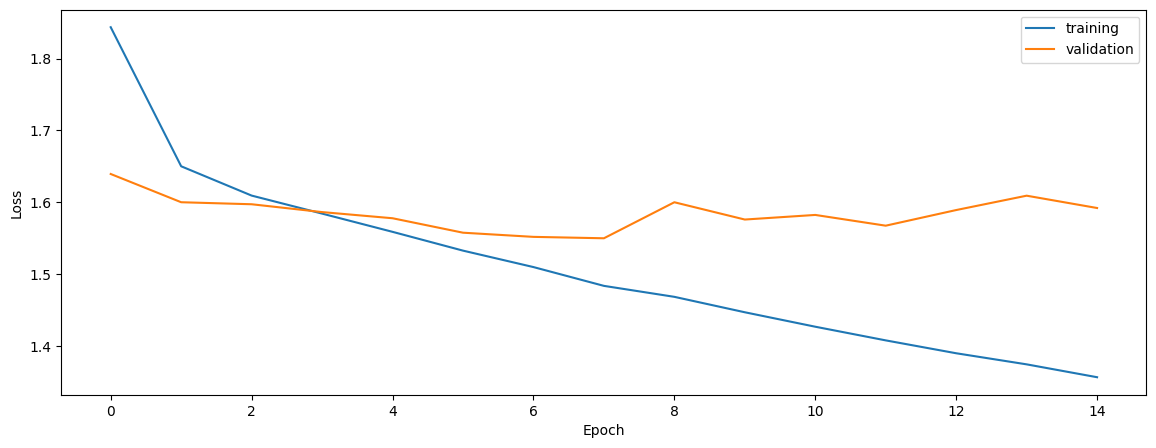

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.4291526919011005
0.4027122133590614
0.35697261751504816


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.4699247091033539
0.4772079388984509
0.400647877492256


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.4666287692824475
0.46913851908900867
0.3979533826037521


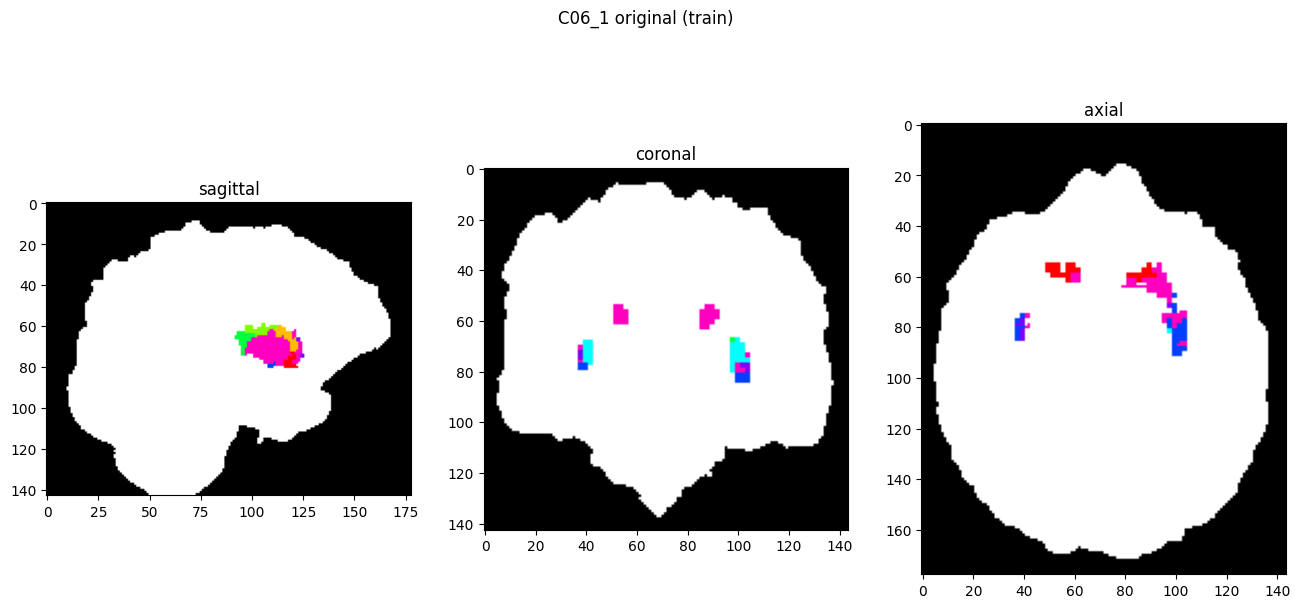

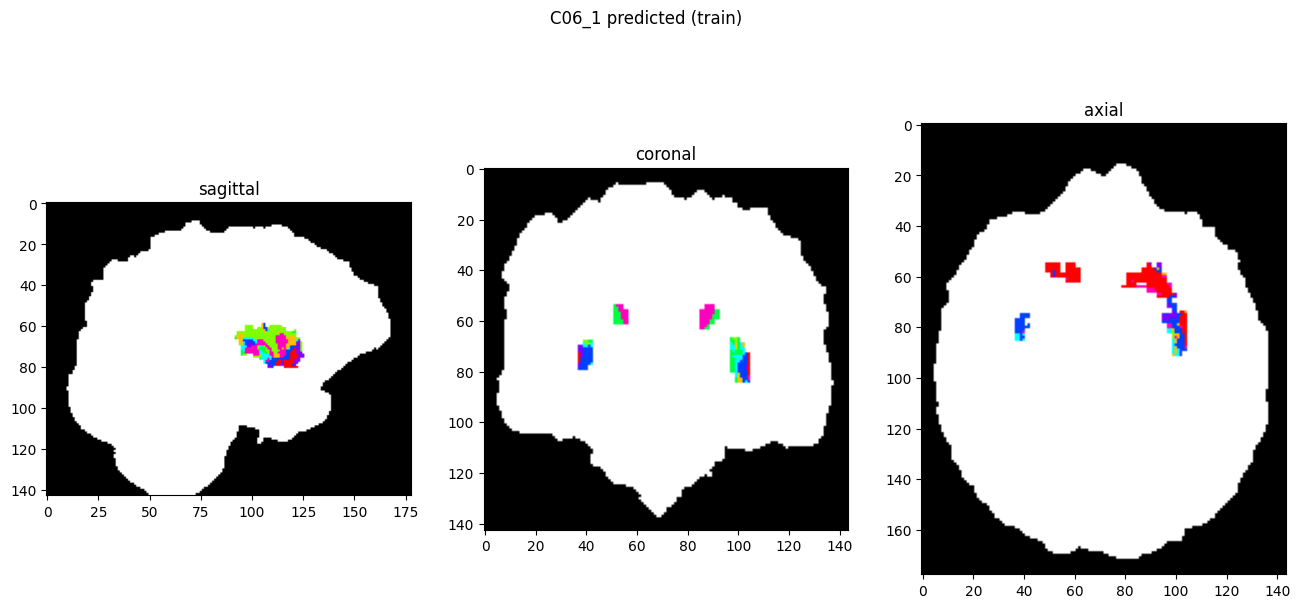

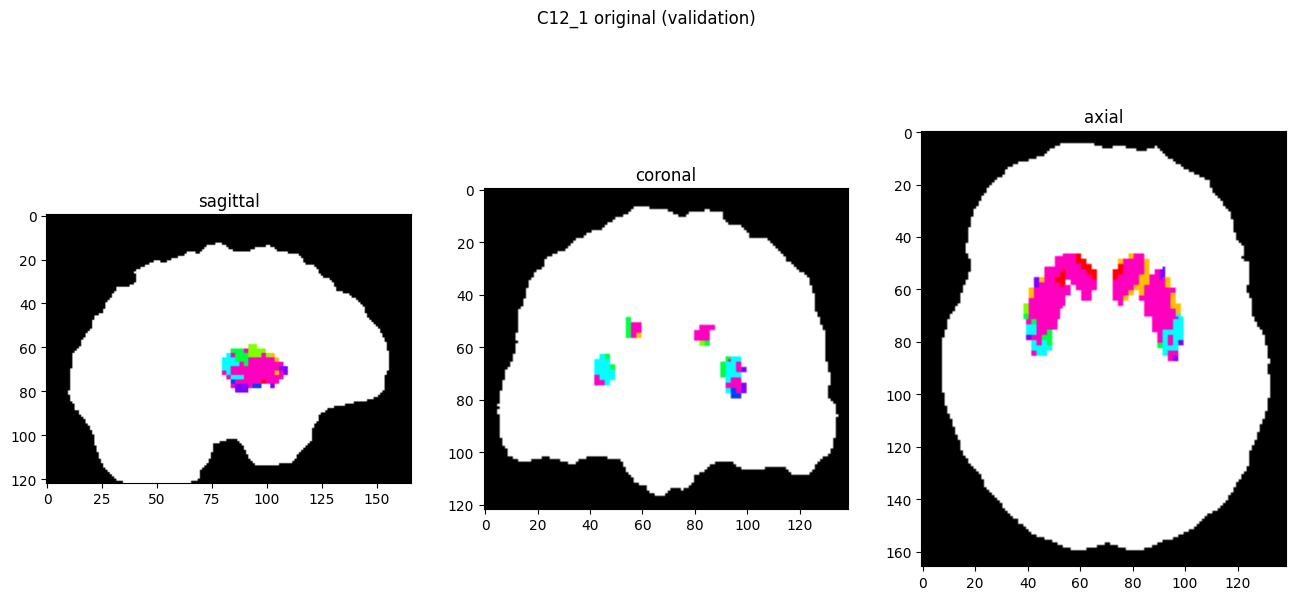

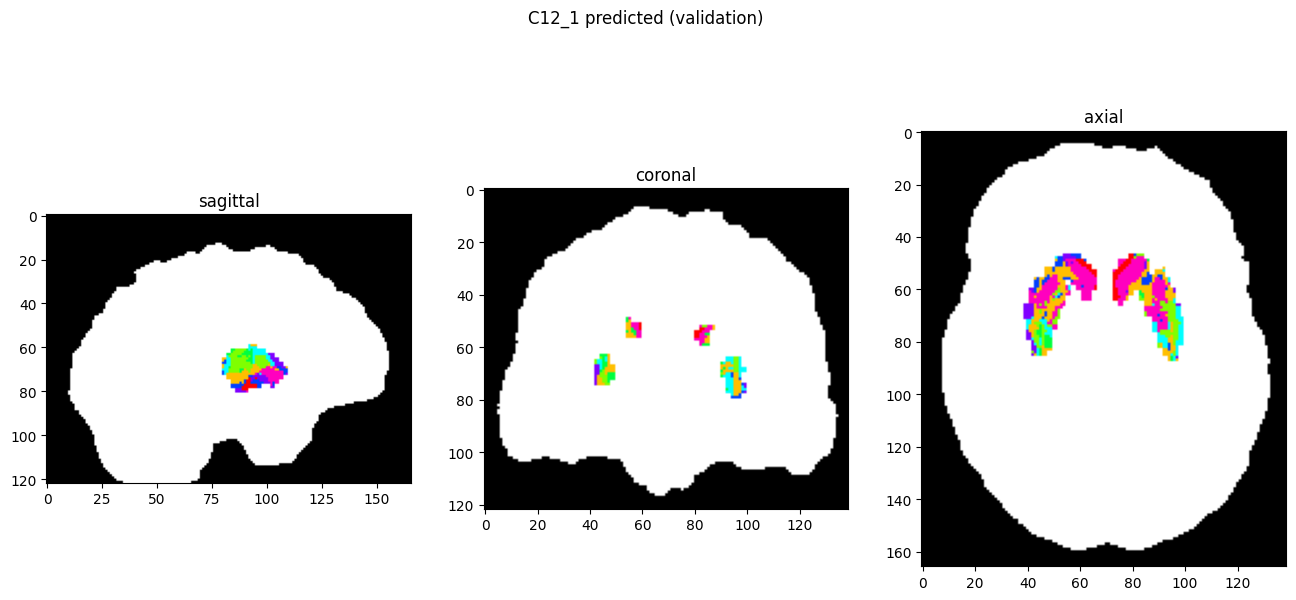

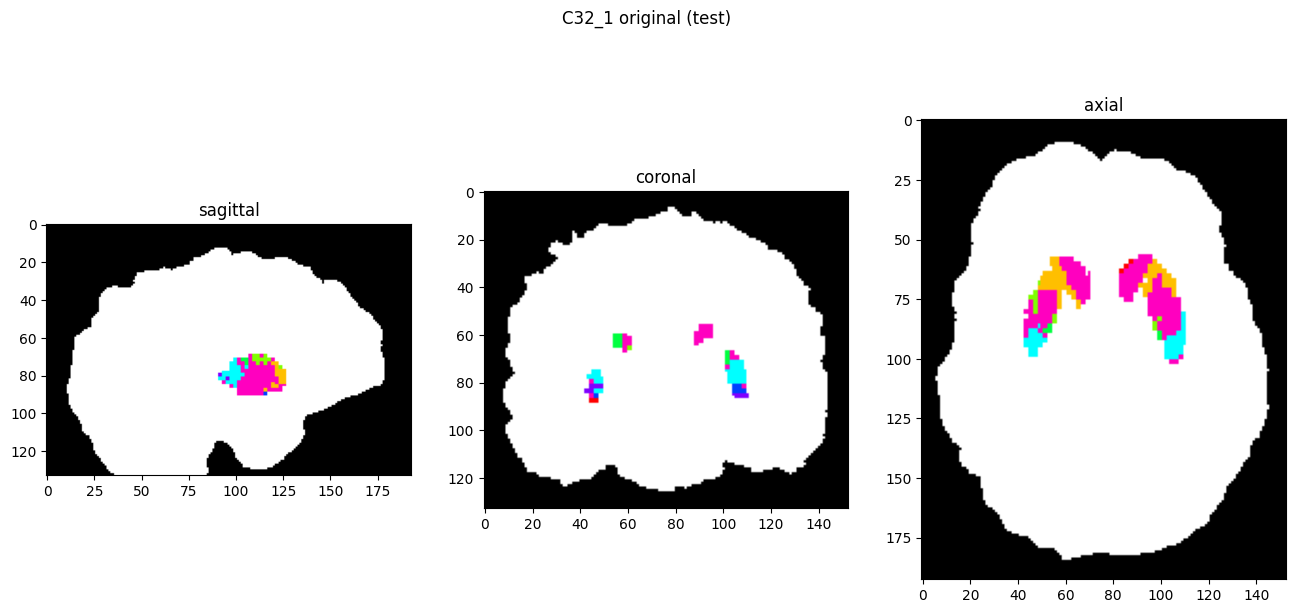

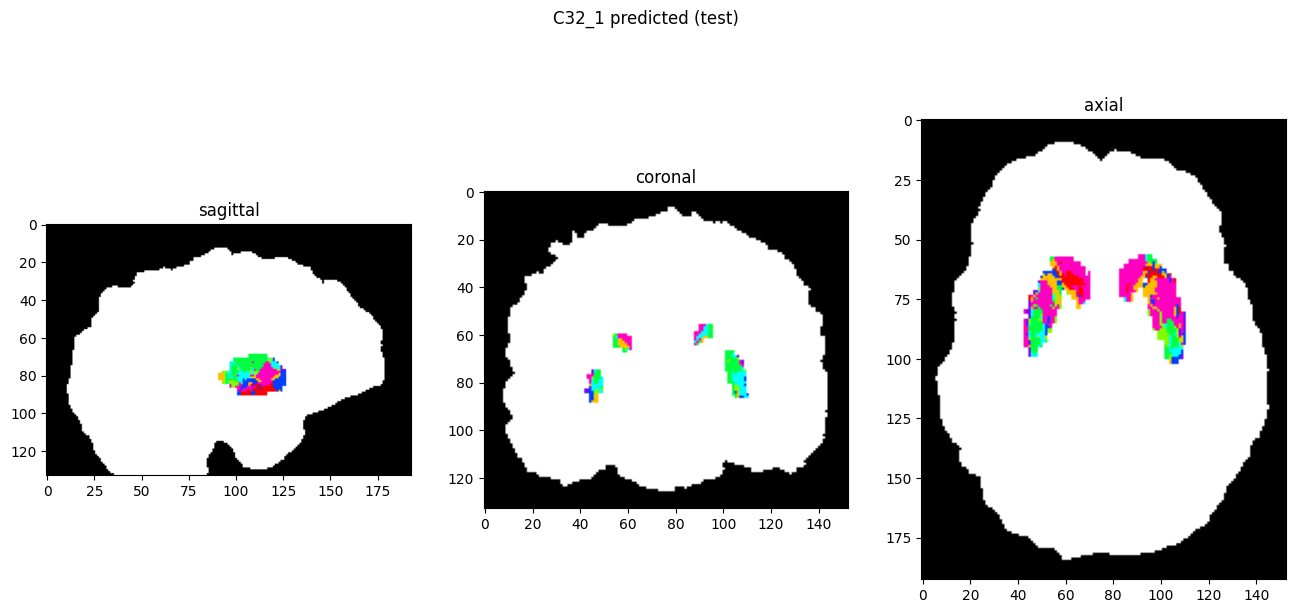

In [10]:
showResults(model, gen, threshold=0)